In [2]:
import numpy as np
import gym
from gym import spaces
from collections import deque
from itertools import permutations

class PickAndPlaceEnv(gym.Env):
    def __init__(self, grid_size=10):
        super(PickAndPlaceEnv, self).__init__()
        self.grid_size = grid_size
        self.start_pos = [0, 0]
        self.final_pos = (grid_size - 1, grid_size - 1)
        self.agent_pos = self.start_pos.copy()
        self.carries = []
        self.obstacles = self._create_corridors()
        self.steps_taken = 0

        # Action space: 4 discrete moves (up, down, left, right)
        self.action_space = spaces.Discrete(4)

        # Observation space: flatten grid plus 2 boolean flags (on_carry, on_goal)
        self.observation_space = spaces.Box(
            low=0, high=1,
            shape=(grid_size * grid_size * 4 + 2,),
            dtype=np.float32
        )

        # Precompute BFS-based shortest paths for all free cells
        self.all_pairs_paths = self._precompute_all_pairs_paths()

        # Track previous distance for distance-based shaping
        self.prev_distance = None

    ###########################################################################
    # A. Obstacle / BFS Setup
    ###########################################################################
    def _create_corridors(self):
        obstacles = []
        for row in range(3, 8):
            obstacles.append((row, self.grid_size // 4))
            obstacles.append((row, 3 * self.grid_size // 4))
            if row != 5 and row != 6:
                obstacles.append((row, self.grid_size // 2))
        return obstacles

    def _precompute_all_pairs_paths(self):
        """
        For every free cell (not an obstacle), run BFS to find
        the shortest path to every other free cell.
        Store (distance, path) in a dict keyed by (start, goal).
        """
        free_cells = [
            (r, c)
            for r in range(self.grid_size)
            for c in range(self.grid_size)
            if (r, c) not in self.obstacles
        ]

        all_pairs = {}
        for cell in free_cells:
            dist_map, path_map = self._bfs_from_cell(cell)
            for other_cell in free_cells:
                if other_cell in dist_map:
                    distance = dist_map[other_cell]
                    path = self._reconstruct_path(cell, other_cell, path_map)
                    all_pairs[(cell, other_cell)] = (distance, path)
        return all_pairs

    def _bfs_from_cell(self, start):
        from collections import deque
        queue = deque([start])
        dist_map = {start: 0}
        path_map = {}

        directions = [(-1,0),(1,0),(0,-1),(0,1)]
        while queue:
            current = queue.popleft()
            for d in directions:
                nr, nc = current[0] + d[0], current[1] + d[1]
                neighbor = (nr, nc)
                if (0 <= nr < self.grid_size and 0 <= nc < self.grid_size and
                        neighbor not in dist_map and
                        neighbor not in self.obstacles):
                    dist_map[neighbor] = dist_map[current] + 1
                    path_map[neighbor] = current
                    queue.append(neighbor)

        return dist_map, path_map

    def _reconstruct_path(self, start, goal, path_map):
        if goal == start:
            return [start]
        if goal not in path_map:
            return []
        path = []
        current = goal
        while current != start:
            path.append(current)
            current = path_map[current]
        path.append(start)
        path.reverse()
        return path

    ###########################################################################
    # B. Gym API: reset / step
    ###########################################################################
    def reset(self, seed=None, return_info=False, options=None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos.copy()
        self.carries = []
        self.steps_taken = 0

        # Randomly place 3 carries
        while len(self.carries) < 3:
            carry = (np.random.randint(1, self.grid_size),
                     np.random.randint(1, self.grid_size))
            if (carry not in self.obstacles and
                carry != self.final_pos and
                carry != tuple(self.agent_pos)):
                self.carries.append(carry)

        # Initialize distance-based shaping measure
        self.prev_distance = self._get_next_target_distance()

        observation = self.get_obs()
        if return_info:
            return observation, {}
        return observation

    def step(self, action, flag=0):
        done = False
        reward = -1  # small time penalty

        old_distance = self.prev_distance

        next_pos = self.get_next_position(action)

        # obstacle collision => big penalty
        if tuple(next_pos) in self.obstacles:
            reward = -300
            done = True
            self.prev_distance = 0.0
            return self.get_obs(), reward, done, {}

        # move
        self.agent_pos = next_pos

        # if pick up a carry
        if tuple(self.agent_pos) in self.carries:
            reward += 100
            self.carries.remove(tuple(self.agent_pos))
            new_distance = self._get_next_target_distance()
            self.prev_distance = new_distance
            return self.get_obs(), reward, done, {}

        # if final
        if not self.carries and tuple(self.agent_pos) == self.final_pos:
            reward += 250
            done = True
            self.prev_distance = 0.0
            return self.get_obs(), reward, done, {}

        # normal shaping
        new_distance = self._get_next_target_distance()
        if flag == 0:
            shaping_reward = (old_distance - new_distance) * 5.0
        else:
            shaping_reward = 0
        reward += shaping_reward

        self.prev_distance = new_distance
        return self.get_obs(), reward, done, {}

    ###########################################################################
    # C. Distance Logic, Observations, and Path-Lookups
    ###########################################################################
    def _get_next_target_distance(self):
        if self.carries:
            dists = [
                np.linalg.norm(np.array(self.agent_pos) - np.array(carry))
                for carry in self.carries
            ]
            return min(dists)
        else:
            return np.linalg.norm(np.array(self.agent_pos) - np.array(self.final_pos))

    def get_obs(self):
        grid = np.zeros((self.grid_size, self.grid_size, 4), dtype=np.float32)
        for obs in self.obstacles:
            grid[obs[0], obs[1], 0] = 1
        for carry in self.carries:
            grid[carry[0], carry[1], 1] = 1
        grid[self.final_pos[0], self.final_pos[1], 2] = 1
        grid[self.agent_pos[0], self.agent_pos[1], 3] = 1

        on_carry = int(tuple(self.agent_pos) in self.carries)
        on_goal = int(tuple(self.agent_pos) == self.final_pos)

        return np.concatenate([grid.flatten(), [on_carry, on_goal]])

    def get_next_position(self, action):
        r, c = self.agent_pos
        if action == 0:  # up
            r = max(0, r - 1)
        elif action == 1:  # down
            r = min(self.grid_size - 1, r + 1)
        elif action == 2:  # left
            c = max(0, c - 1)
        elif action == 3:  # right
            c = min(self.grid_size - 1, c + 1)
        return (r, c)

    def get_action_from_positions(self, current_pos, next_pos):
        if next_pos[0] < current_pos[0]:
            return 0  # Up
        elif next_pos[0] > current_pos[0]:
            return 1  # Down
        elif next_pos[1] < current_pos[1]:
            return 2  # Left
        elif next_pos[1] > current_pos[1]:
            return 3  # Right
        return None

    def get_astar_path(self, start_pos=None, final_pos=None):
        if start_pos is None:
            start_pos = tuple(self.agent_pos)
        if final_pos is None:
            final_pos = self.final_pos

        # If no carries, just direct path to final
        if not self.carries:
            return self._lookup_path(start_pos, final_pos)

        carry_list = list(self.carries)
        best_path = []
        best_len = float('inf')

        for perm in permutations(carry_list):
            subpath = self._lookup_path(start_pos, perm[0])
            if not subpath:
                continue
            route = subpath[:-1]

            fail = False
            for i in range(len(perm) - 1):
                segment = self._lookup_path(perm[i], perm[i+1])
                if not segment:
                    fail = True
                    break
                route += segment[:-1]
            if fail:
                continue

            segment = self._lookup_path(perm[-1], final_pos)
            if not segment:
                continue
            route += segment

            if len(route) < best_len:
                best_len = len(route)
                best_path = route

        return best_path

    def _lookup_path(self, cell_a, cell_b):
        if (cell_a, cell_b) not in self.all_pairs_paths:
            return []
        dist, path = self.all_pairs_paths[(cell_a, cell_b)]
        return path

    ###########################################################################
    # D. The new function to generate BFS transitions
    ###########################################################################
    def get_astar_transitions(self):
        """
        Return a list of (state, action, reward, next_state, done) by
        stepping along the A* path. We'll do this in a 'temp' approach,
        then restore the environment.
        """
        path = self.get_astar_path()  # path from agent_pos through carries + final
        transitions = []

        # Save original environment state
        saved_pos = tuple(self.agent_pos)
        saved_carries = list(self.carries)
        saved_prev_distance = self.prev_distance

        for i in range(len(path) - 1):
            current_pos = path[i]
            next_pos = path[i+1]
            action = self.get_action_from_positions(current_pos, next_pos)

            # forcibly set env to current_pos
            self.agent_pos = current_pos

            # step
            state = self.get_obs()
            next_obs, reward, done, _ = self.step(action)
            transitions.append((state, action, reward, next_obs, done))

            if done:
                break

        # restore environment
        self.agent_pos = saved_pos
        self.carries = saved_carries
        self.prev_distance = saved_prev_distance

        return transitions


In [3]:
import math
import os
import numpy as np
import random
import tensorflow as tf
import keras as ks
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from collections import deque
from itertools import permutations
from google.colab import drive

###############################################################################
# 1. Hyperparameters & Setup
###############################################################################
LEARNING_RATE = 1e-4
GAMMA = 0.99
BATCH_SIZE = 128
MAX_STEPS_PER_EPISODE = 50
TRAIN_FREQUENCY = 4
TARGET_UPDATE_FREQUENCY = 200

EPSILON_START = 1.0
EPSILON_DECAY = 0.9995
MIN_EPSILON = 0.05

NUM_EPISODES = 25200

PRIORITY_ALPHA = 0.6
PRIORITY_BETA_START = 0.4
PRIORITY_BETA_END = 1.0

drive.mount('/content/drive')
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints_lastt'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Offline BFS demos
N_OFFLINE_DEMOS = 500
BC_EPOCHS = 3

# Distributional constants for C51
NUM_ATOMS = 51
V_MIN = -10.0
V_MAX = 10.0
supports = np.linspace(V_MIN, V_MAX, NUM_ATOMS, dtype=np.float32)

###############################################################################
# 2. Noisy Dense Layer
###############################################################################
class NoisyDense(layers.Layer):
    """
    Factorized NoisyNet implementation from Rainbow.
    """
    def __init__(self, units, activation=None, sigma_init=0.5, **kwargs):
        super(NoisyDense, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.sigma_init = sigma_init

    def build(self, input_shape):
        in_dim = int(input_shape[-1])

        # trainable parameters
        self.W_mu = self.add_weight(
            shape=(in_dim, self.units),
            initializer='glorot_uniform',
            name='W_mu'
        )
        self.W_sigma = self.add_weight(
            shape=(in_dim, self.units),
            initializer=ks.initializers.Constant(
                value=self.sigma_init / math.sqrt(in_dim)
            ),
            name='W_sigma'
        )

        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='b_mu'
        )
        self.b_sigma = self.add_weight(
            shape=(self.units,),
            initializer=ks.initializers.Constant(
                value=self.sigma_init / math.sqrt(in_dim)
            ),
            name='b_sigma'
        )

    def call(self, inputs, training=None):
        # Factorized noise
        batch_size = tf.shape(inputs)[0]
        in_dim = tf.shape(inputs)[-1]

        eps_in = tf.random.normal((batch_size, in_dim))
        eps_out = tf.random.normal((batch_size, self.units))

        def f(x):
            return tf.sign(x) * tf.sqrt(tf.abs(x))

        eps_in = f(eps_in)
        eps_out = f(eps_out)

        W_noise = tf.einsum('bi,bj->bij', eps_in, eps_out)  # shape (batch, in_dim, units)
        b_noise = eps_out  # shape (batch, units)

        W = tf.expand_dims(self.W_mu, 0) + self.W_sigma * W_noise
        b = tf.expand_dims(self.b_mu, 0) + self.b_sigma * b_noise

        # shape: (batch, in_dim) * (batch, in_dim, units) => (batch, units)
        y = tf.einsum('bi,bij->bj', inputs, W) + b

        if self.activation is not None:
            act_fn = getattr(tf.nn, self.activation)
            y = act_fn(y)
        return y

###############################################################################
# 3. Build a Distributional Dueling Q-Network (Rainbow-Style)
###############################################################################
def build_rainbow_distributional_q_network(state_dim, action_dim):
    """
    Returns a model output shape: (batch, action_dim, NUM_ATOMS).
    We'll apply softmax over the last dimension to ensure a valid probability distribution.
    """
    inputs = layers.Input(shape=(state_dim,), name='states')

    # Noisy MLP
    x = NoisyDense(256, activation='relu')(inputs)
    x = NoisyDense(128, activation='relu')(x)

    # Value stream => shape (batch, action_dim * num_atoms)
    val = NoisyDense(action_dim * NUM_ATOMS)(x)
    val = layers.Reshape((action_dim, NUM_ATOMS))(val)
    # We'll reduce along axis=1 (the action_dim) => shape (batch, 1, NUM_ATOMS)
    val = layers.Lambda(
        lambda t: tf.reduce_mean(t, axis=1, keepdims=True),
        output_shape=(1, NUM_ATOMS)
    )(val)

    # Advantage stream => shape (batch, action_dim, num_atoms)
    adv = NoisyDense(action_dim * NUM_ATOMS)(x)
    adv = layers.Reshape((action_dim, NUM_ATOMS))(adv)

    # *** Key fix: use Lambda layer for reduce_mean with output_shape ***
    adv_mean = layers.Lambda(
        lambda t: tf.reduce_mean(t, axis=1, keepdims=True),
        output_shape=(1, NUM_ATOMS)
    )(adv)

    centered_adv = layers.Subtract()([adv, adv_mean])
    dist = layers.Add()([val, centered_adv])

    # final softmax across the num_atoms dimension
    dist_probs = layers.Softmax(axis=-1)(dist)

    model = ks.Model(inputs=inputs, outputs=dist_probs, name='rainbow_c51')
    return model

###############################################################################
# 4. Project Distribution (C51)
###############################################################################
def project_distribution(rewards, dones, gamma, next_dist,
                         v_min, v_max, num_atoms):
    """
    next_dist: (batch, num_atoms) distribution for next state-action chosen
    We'll project onto [v_min, v_max].
    Output: (batch, num_atoms).
    """
    batch_size = rewards.shape[0]
    delta_z = (v_max - v_min) / (num_atoms - 1)
    target_dist = np.zeros((batch_size, num_atoms), dtype=np.float32)

    for b in range(batch_size):
        if dones[b]:
            # all mass at reward
            Tz = np.clip(rewards[b], v_min, v_max)
            bin_ = (Tz - v_min) / delta_z
            low = int(np.floor(bin_))
            high = int(np.ceil(bin_))
            if low == high:
                target_dist[b, low] = 1.0
            else:
                ratio = bin_ - low
                target_dist[b, low] = 1.0 - ratio
                target_dist[b, high] = ratio
        else:
            # distribute next_dist
            for atom_idx in range(num_atoms):
                z_j = v_min + atom_idx * delta_z
                Tz = rewards[b] + gamma * z_j
                Tz = np.clip(Tz, v_min, v_max)
                bin_ = (Tz - v_min) / delta_z
                low = int(np.floor(bin_))
                high = int(np.ceil(bin_))
                if low == high:
                    target_dist[b, low] += next_dist[b, atom_idx]
                else:
                    ratio = bin_ - low
                    target_dist[b, low] += next_dist[b, atom_idx] * (1 - ratio)
                    target_dist[b, high] += next_dist[b, atom_idx] * ratio

    return target_dist

###############################################################################
# 5. Example Prioritized Replay Buffer + BFS Demos + Training
###############################################################################
class PrioritizedReplayBuffer:
    def __init__(self, capacity=20000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def add(self, experience, error):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = max(max_priority, abs(error) + 1e-6)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return [], [], []
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        experiences = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        return experiences, indices, weights

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            self.priorities[idx] = abs(error) + 1e-6

def sample_balanced(buffer, batch_size, astar_fraction=0.4, beta=0.4):
    astar_size = int(astar_fraction * batch_size)
    normal_size = batch_size - astar_size

    astar_exps, astar_idxs, astar_weights = buffer.sample(astar_size, beta=beta)
    norm_exps, norm_idxs, norm_weights = buffer.sample(normal_size, beta=beta)

    experiences = astar_exps + norm_exps
    indices = np.concatenate([astar_idxs, norm_idxs])
    weights = np.concatenate([astar_weights, norm_weights])
    return experiences, indices, weights

def generate_astar_transitions(env):
    return env.get_astar_transitions()

def collect_offline_bfs_demos(env, replay_buffer, n_episodes=500):
    for _ in range(n_episodes):
        env.reset()
        transitions = generate_astar_transitions(env)
        for (s, a, r, ns, d) in transitions:
            replay_buffer.add((s, a, r, ns, d), 100.0)

def supervised_pretraining(model, replay_buffer, epochs=3, batch_size=128, gamma=0.99):
    if len(replay_buffer.buffer) == 0:
        print("[Warning] Replay buffer is empty; skipping pretraining.")
        return
    # etc. as needed...

def linear_schedule(current_step, total_steps, start_val, end_val):
    fraction = min(float(current_step) / total_steps, 1.0)
    return start_val + fraction * (end_val - start_val)

###############################################################################
# 6. The main training script
###############################################################################
def main():

    env = PickAndPlaceEnv(grid_size=10)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    rainbow_model = build_rainbow_distributional_q_network(state_dim, action_dim)
    target_model  = build_rainbow_distributional_q_network(state_dim, action_dim)
    target_model.set_weights(rainbow_model.get_weights())

    optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)

    replay_buffer = PrioritizedReplayBuffer(capacity=20000, alpha=PRIORITY_ALPHA)

    print("[Stage] Collecting offline BFS demonstrations...")
    collect_offline_bfs_demos(env, replay_buffer, n_episodes=N_OFFLINE_DEMOS)
    print(f"[Info] Replay buffer after BFS pre-fill: {len(replay_buffer.buffer)}")

    print("[Stage] Doing supervised pretraining (optional)...")
    supervised_pretraining(rainbow_model, replay_buffer, epochs=BC_EPOCHS, batch_size=BATCH_SIZE, gamma=GAMMA)

    # Save initial
    rainbow_model.save(os.path.join(CHECKPOINT_DIR, "rainbow_initial.keras"))

    epsilon = EPSILON_START
    episode_rewards = []
    obstacle_hits = 0
    successful_episodes = 0
    total_steps = 0

    global_step = 0
    max_global_steps = NUM_EPISODES * MAX_STEPS_PER_EPISODE
    carry_counts = []

    for episode in range(NUM_EPISODES):
        state = env.reset()
        done = False
        ep_reward = 0
        carries_collected = 0

        # BFS injection
        astar_transitions = generate_astar_transitions(env)
        for (s, a, r, ns, d) in astar_transitions:
            replay_buffer.add((s, a, r, ns, d), 100.0)

        for step_i in range(MAX_STEPS_PER_EPISODE):
            global_step += 1

            # Epsilon + Noisy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                dist = rainbow_model.predict(state.reshape(1,-1), verbose=0)[0]
                # E[Q(action)] = sum( z_i * p_i )
                q_vals = np.sum(dist * supports, axis=1)
                action = np.argmax(q_vals)

            next_state, reward, done, info = env.step(action)

            if reward == -300:
                obstacle_hits += 1

            if reward >= 90 and reward < 190:
                carries_collected += 1

            replay_buffer.add((state, action, reward, next_state, done), abs(reward))

            state = next_state
            ep_reward += reward

            if done:
                if not env.carries and tuple(env.agent_pos) == env.final_pos:
                    successful_episodes += 1
                break

            # Training step
            if (len(replay_buffer.buffer) >= BATCH_SIZE) and (step_i % TRAIN_FREQUENCY == 0):
                current_beta = linear_schedule(global_step, max_global_steps, PRIORITY_BETA_START, PRIORITY_BETA_END)
                experiences, indices, weights = sample_balanced(
                    replay_buffer, BATCH_SIZE, astar_fraction=0.4, beta=current_beta
                )
                if len(experiences) > 0:
                    states_mb = np.array([e[0] for e in experiences])
                    actions_mb = np.array([e[1] for e in experiences])
                    rewards_mb = np.array([e[2] for e in experiences], dtype=np.float32)
                    next_states_mb = np.array([e[3] for e in experiences])
                    dones_mb = np.array([e[4] for e in experiences], dtype=np.bool_)

                    dist_next_online = rainbow_model.predict(next_states_mb, verbose=0)
                    dist_next_target = target_model.predict(next_states_mb, verbose=0)

                    exp_q_next_online = np.sum(dist_next_online * supports, axis=2)
                    best_next_action = np.argmax(exp_q_next_online, axis=1)

                    chosen_next_dist = []
                    for i in range(len(experiences)):
                        chosen_next_dist.append(dist_next_target[i, best_next_action[i]])
                    chosen_next_dist = np.array(chosen_next_dist)

                    target_dist = project_distribution(
                        rewards_mb, dones_mb, GAMMA, chosen_next_dist,
                        V_MIN, V_MAX, NUM_ATOMS
                    )

                    with tf.GradientTape() as tape:
                        dist_pred = rainbow_model(states_mb, training=True)  # (batch, action_dim, num_atoms)
                        one_hot_a = tf.one_hot(actions_mb, depth=dist_pred.shape[1])  # (batch, action_dim)
                        dist_chosen = tf.reduce_sum(dist_pred * one_hot_a[:,:,None], axis=1)  # (batch, num_atoms)

                        target_dist_tf = tf.constant(target_dist, dtype=tf.float32)
                        loss_per_example = -tf.reduce_sum(
                            target_dist_tf * tf.math.log(dist_chosen + 1e-8), axis=1
                        )
                        w = tf.constant(weights, dtype=tf.float32)
                        loss = tf.reduce_mean(loss_per_example * w)

                    grads = tape.gradient(loss, rainbow_model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, rainbow_model.trainable_variables))

                    errors_numpy = loss_per_example.numpy()
                    replay_buffer.update_priorities(indices, errors_numpy)

            # Update target network
            if global_step % TARGET_UPDATE_FREQUENCY == 0:
                target_model.set_weights(rainbow_model.get_weights())

        episode_rewards.append(ep_reward)
        total_steps += step_i
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
        carry_counts.append(carries_collected)

        if episode % 50 == 0 and episode > 0:
            avg_r = np.mean(episode_rewards[-50:])
            total_carries_50 = sum(carry_counts[-50:])
            avg_steps_last_50 = total_steps / episode

            print(f"Episode {episode}, Last50AvgReward: {avg_r:.2f}, "
                  f"CarriesCollected(last50) total:{total_carries_50}, "
                  f"ObstacleHits: {obstacle_hits}, "
                  f"SuccessEps: {successful_episodes}, "
                  f"AvgStepsTaken(last50): {avg_steps_last_50:.2f}")

            obstacle_hits = 0
            successful_episodes = 0

        if episode % 1000 == 0:
            path = os.path.join(CHECKPOINT_DIR, f"rainbow_model_{episode}.keras")
            rainbow_model.save(path)
            print(f"[INFO] Model saved at {path}")

    print("[Final] Training done!")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Stage] Collecting offline BFS demonstrations...
[Info] Replay buffer after BFS pre-fill: 11430
[Stage] Doing supervised pretraining (optional)...


KeyboardInterrupt: 


Episode 1, Reward: 588.64, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



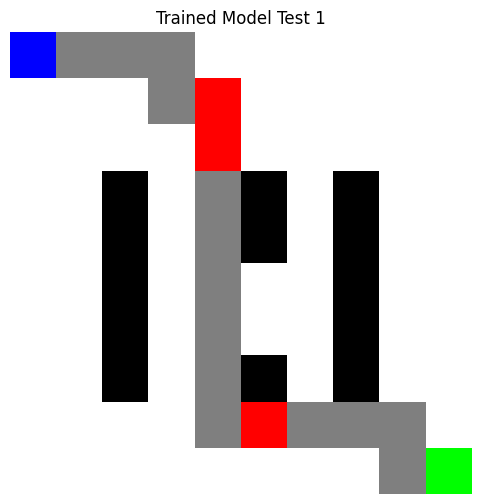


Episode 2, Reward: 603.60, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (8, 7), (9, 7), (9, 6), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



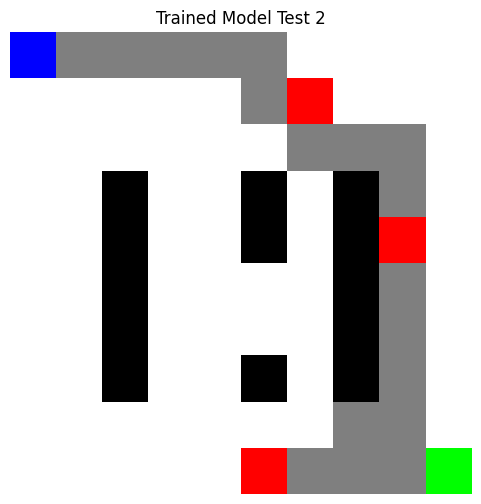


Episode 3, Reward: 624.88, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (1, 7), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (5, 9), (6, 9), (7, 9), (7, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



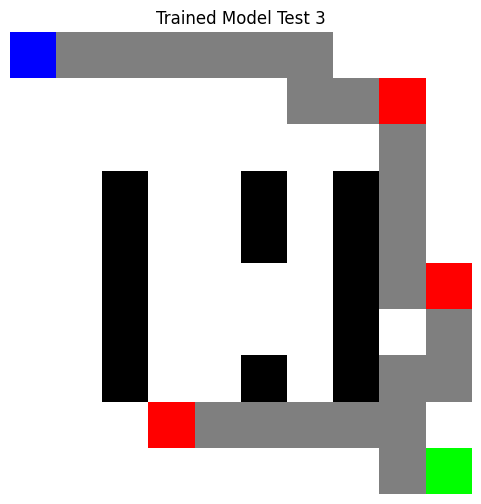


Episode 4, Reward: 590.24, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



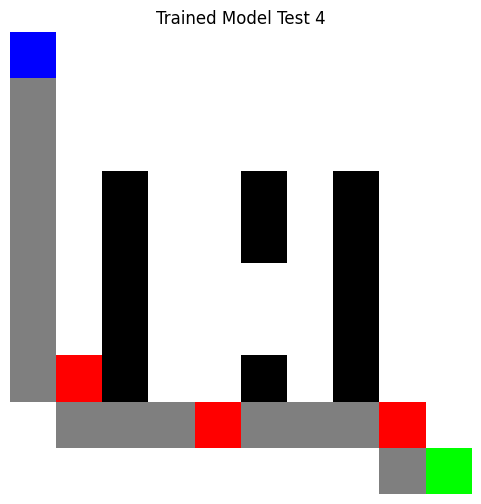


Episode 5, Reward: 594.34, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 7), (2, 8), (2, 9), (2, 8), (2, 9), (2, 8), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



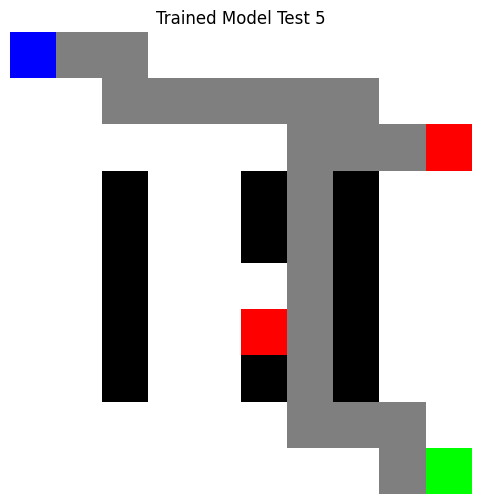


Episode 6, Reward: 607.25, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (7, 4), (8, 4), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



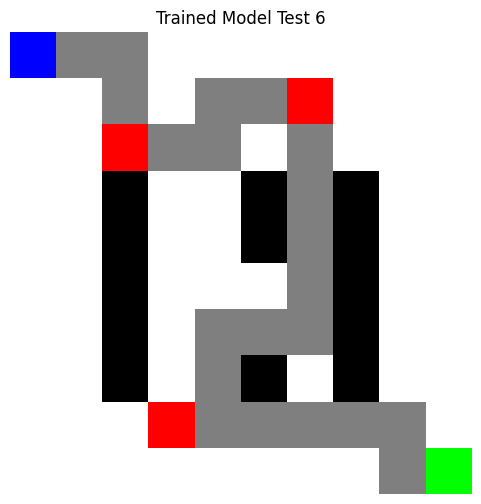


Episode 7, Reward: 582.55, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (4, 1), (3, 1), (2, 1), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



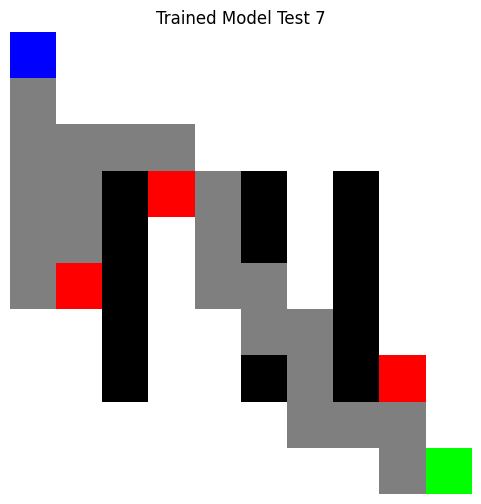


Episode 8, Reward: 589.70, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



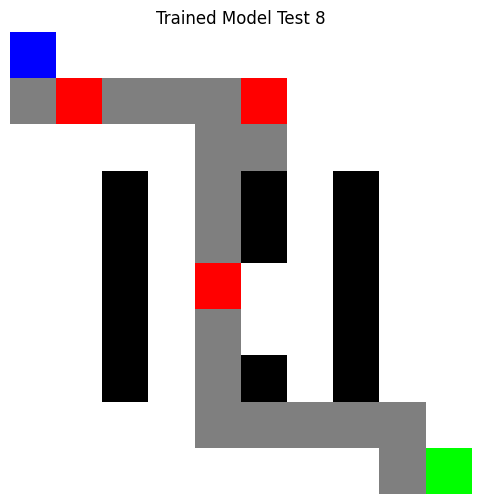


Episode 9, Reward: 593.80, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



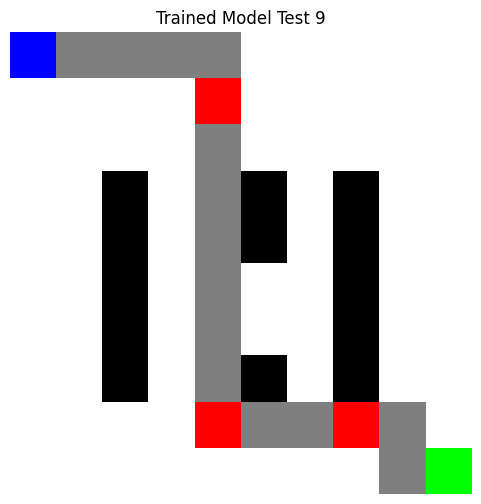


Episode 10, Reward: 614.52, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]



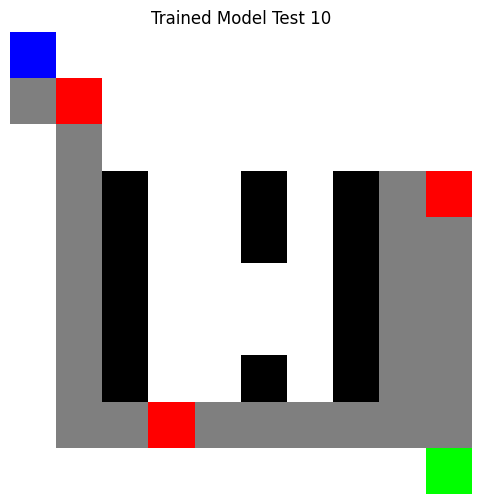


Episode 11, Reward: 612.26, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (6, 5), (6, 4), (6, 3), (7, 3), (8, 3), (8, 2), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



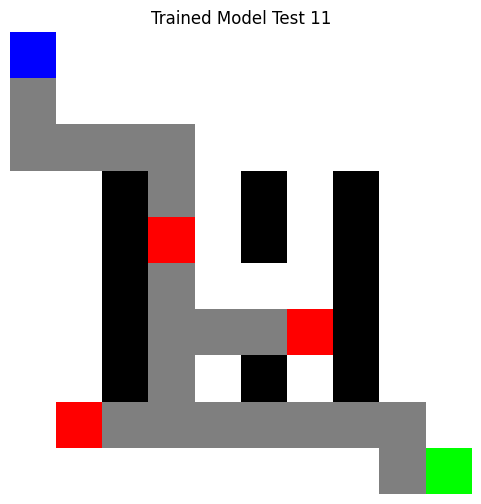


Episode 12, Reward: 596.64, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (9, 3), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (8, 9), (9, 9)]



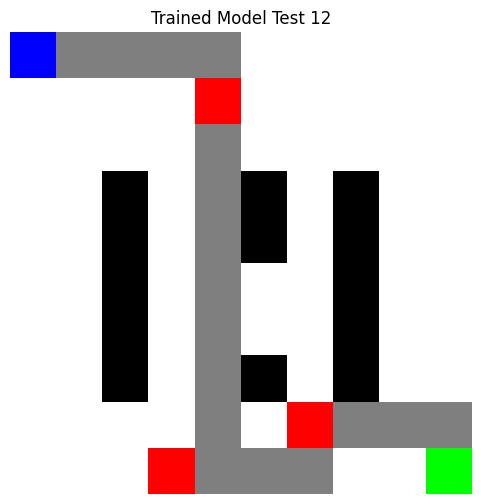


Episode 13, Reward: 577.72, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (8, 9), (7, 9), (8, 9), (9, 9)]



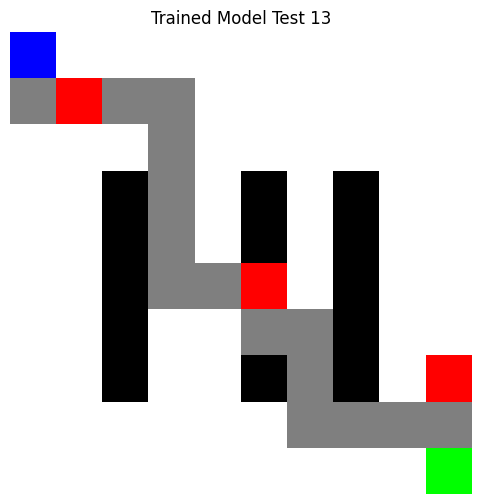


Episode 14, Reward: 581.86, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



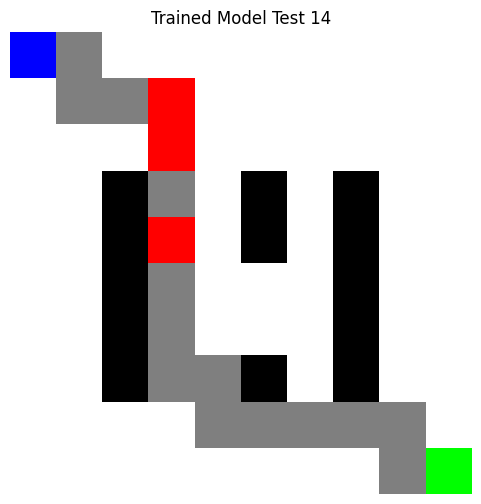


Episode 15, Reward: 202.22, CarriesCollected total: 2, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (7, 4), (6, 4), (6, 5), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5), (5, 6), (5, 5)]



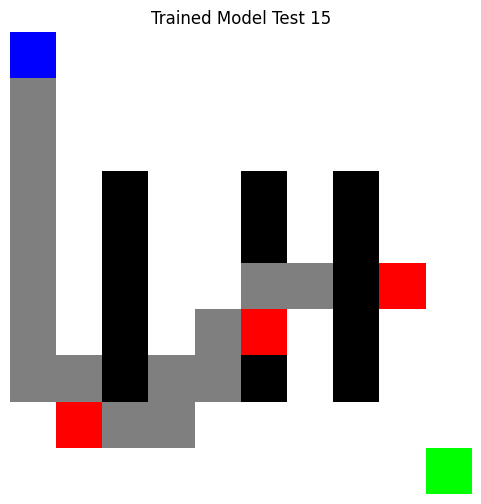


Episode 16, Reward: 594.04, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



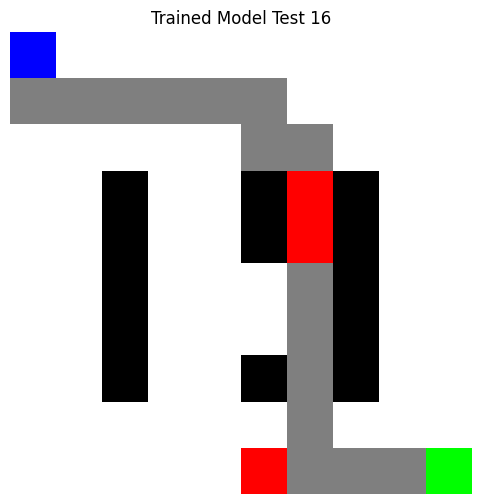


Episode 17, Reward: 584.30, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (1, 1), (2, 1), (2, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (6, 3), (7, 3), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



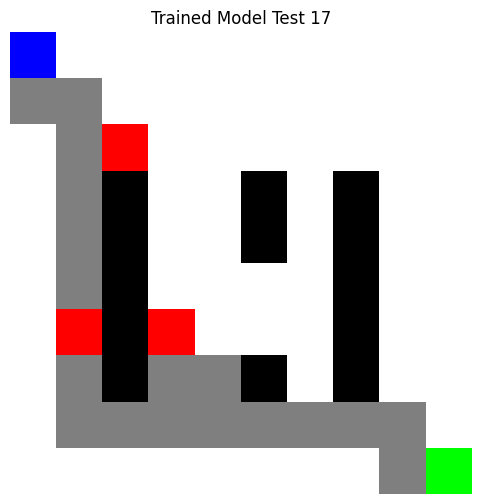


Episode 18, Reward: 579.30, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



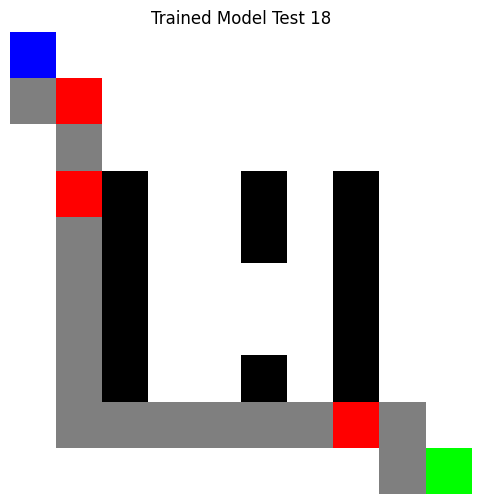


Episode 19, Reward: 591.51, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (2, 3), (2, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (6, 3), (7, 3), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



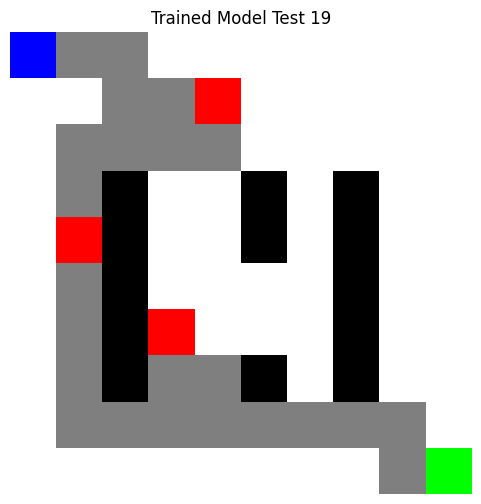


Episode 20, Reward: 602.43, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (1, 7), (1, 8), (2, 8), (3, 8), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (8, 8), (8, 7), (9, 7), (9, 6), (9, 7), (9, 8), (9, 9)]



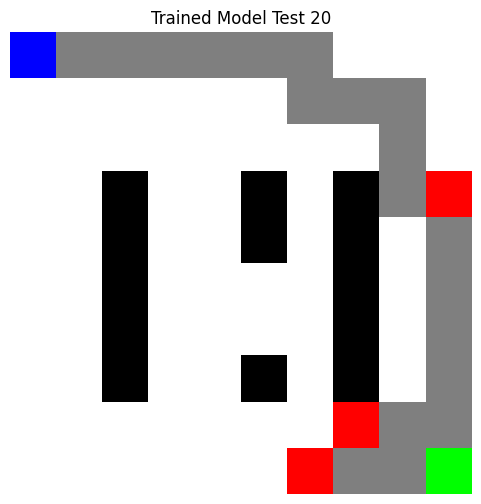


Episode 21, Reward: 585.97, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



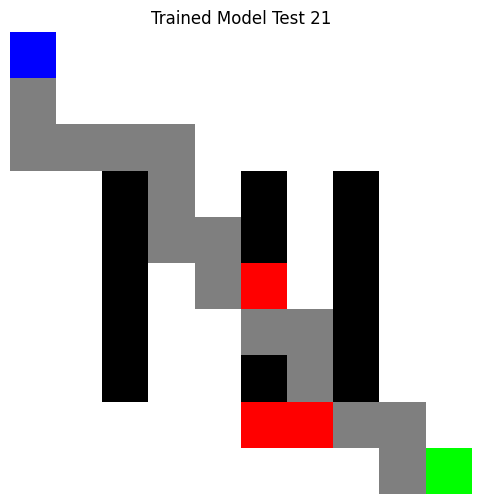


Episode 22, Reward: 580.35, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



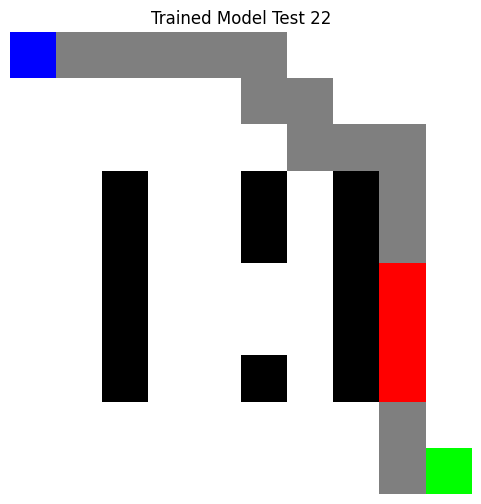


Episode 23, Reward: 585.39, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (6, 4), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



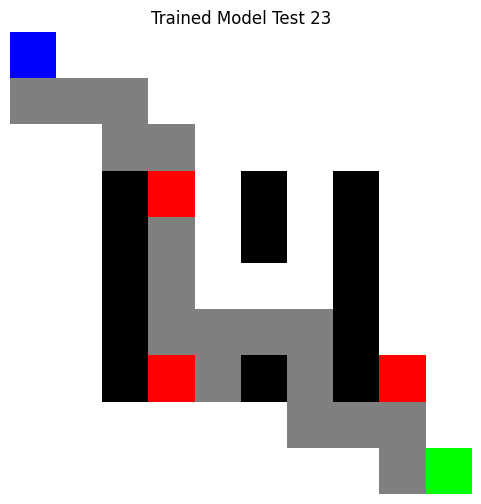


Episode 24, Reward: 582.44, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (6, 9), (7, 9), (8, 9), (8, 8), (9, 8), (9, 9)]



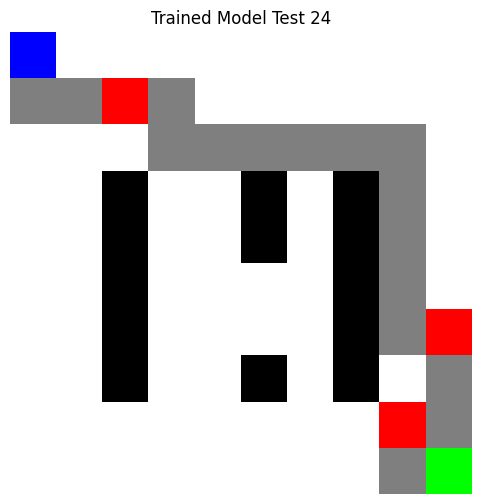


Episode 25, Reward: 584.18, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



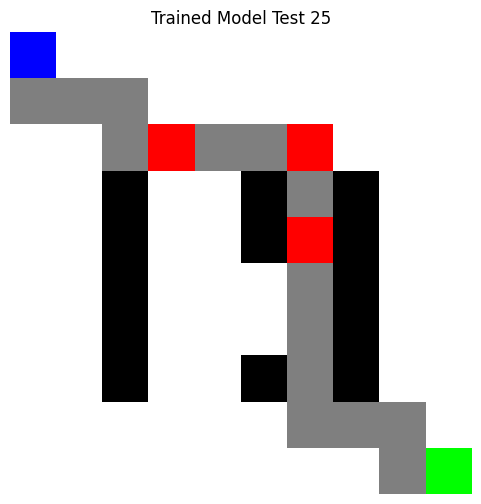


Episode 26, Reward: 599.82, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (5, 5), (6, 5), (6, 4), (7, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



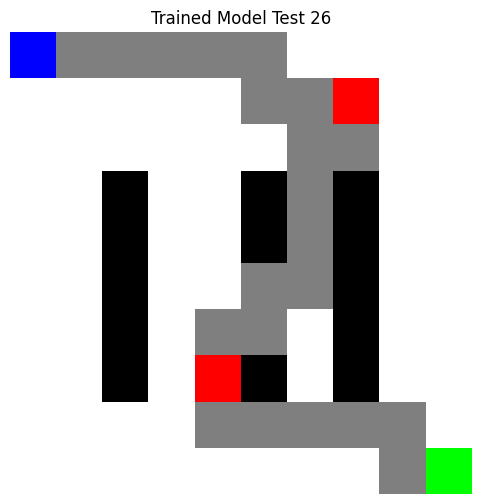


Episode 27, Reward: 610.46, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (5, 5), (6, 5), (6, 4), (7, 4), (8, 4), (8, 3), (8, 2), (9, 2), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



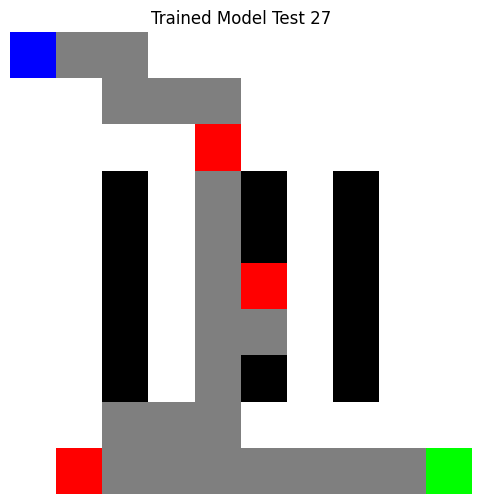


Episode 28, Reward: 579.15, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (6, 4), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



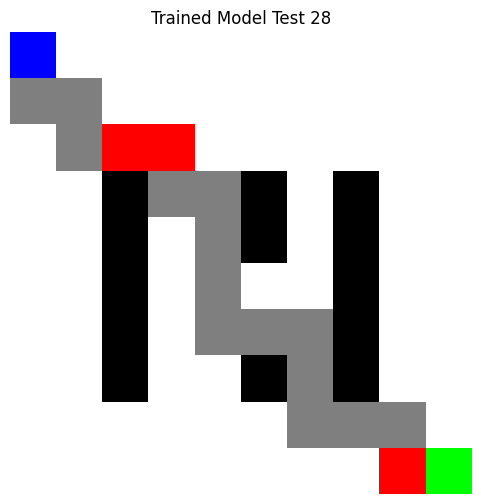


Episode 29, Reward: 600.70, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (5, 5), (6, 5), (6, 4), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



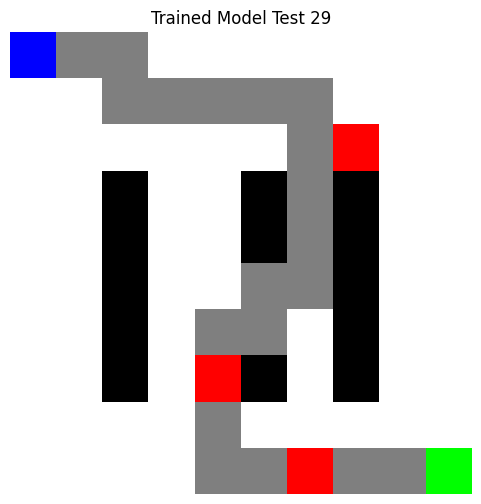


Episode 30, Reward: 593.80, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



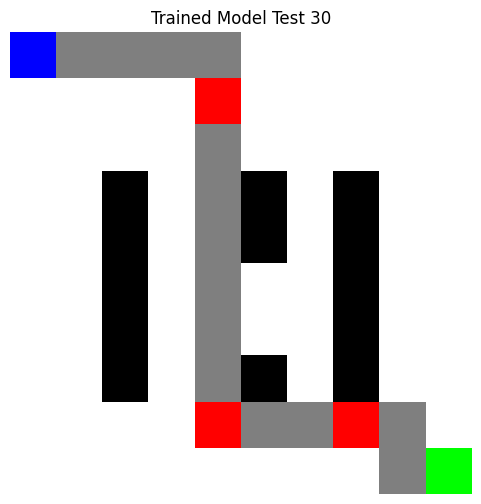


Episode 31, Reward: 175.36, CarriesCollected total: 2, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6)]



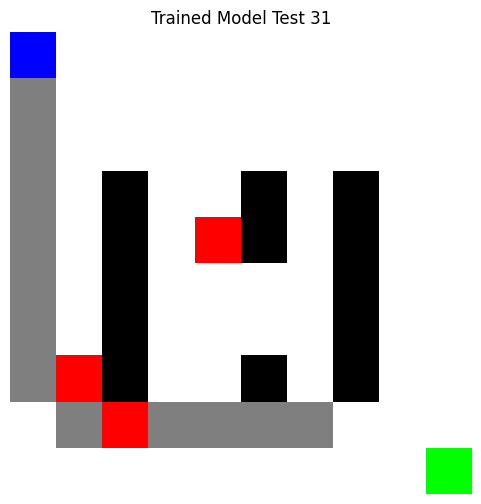


Episode 32, Reward: 618.80, CarriesCollected total: 3, StepsTaken: 32, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (6, 9), (6, 8), (7, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (7, 4), (7, 3), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



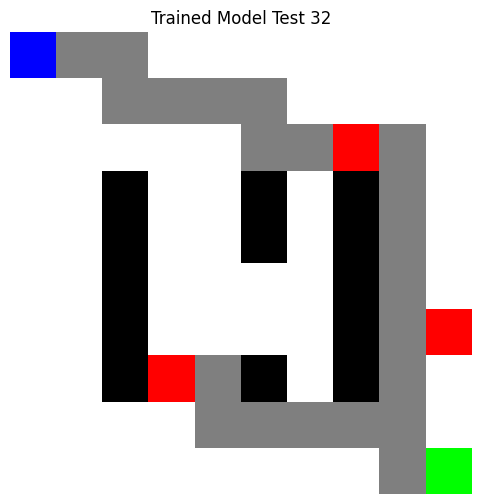


Episode 33, Reward: 596.92, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



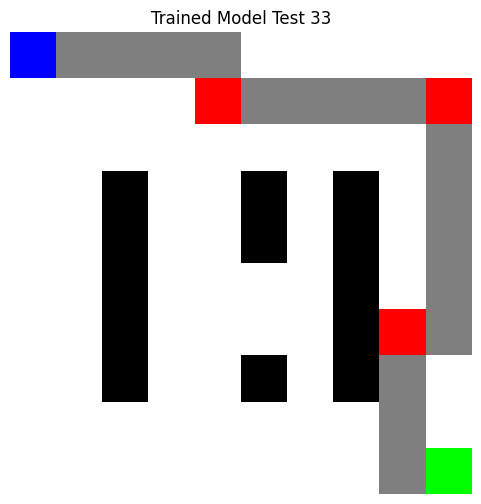


Episode 34, Reward: 586.44, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]



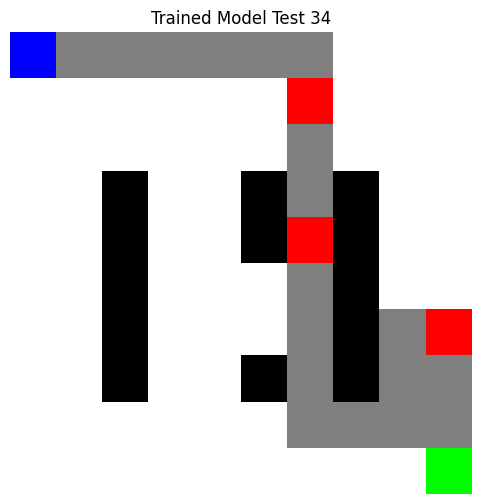


Episode 35, Reward: 599.81, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (6, 5), (5, 5), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]



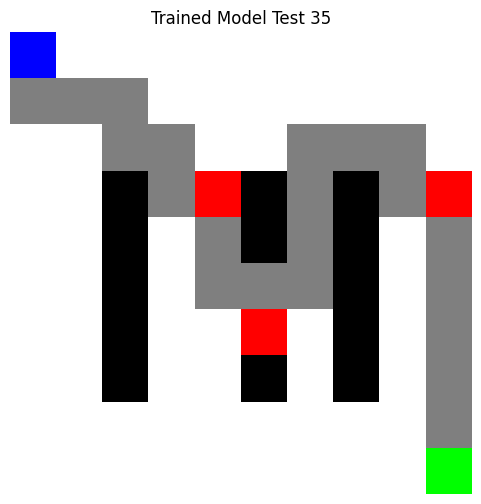


Episode 36, Reward: 294.44, CarriesCollected total: 3, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (5, 6), (4, 6), (3, 6), (4, 6)]



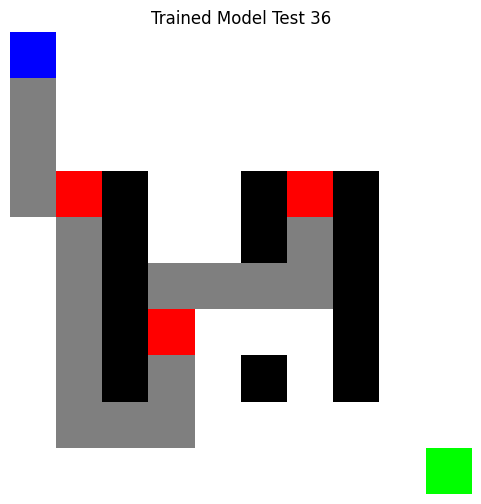


Episode 37, Reward: 586.61, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (6, 4), (6, 5), (6, 6), (7, 6), (8, 6), (9, 6), (8, 6), (8, 7), (8, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



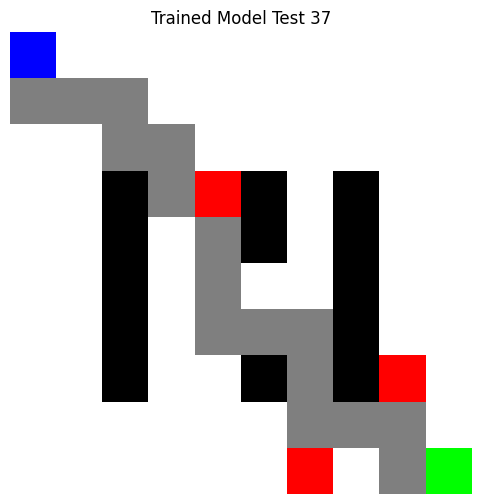


Episode 38, Reward: 588.23, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



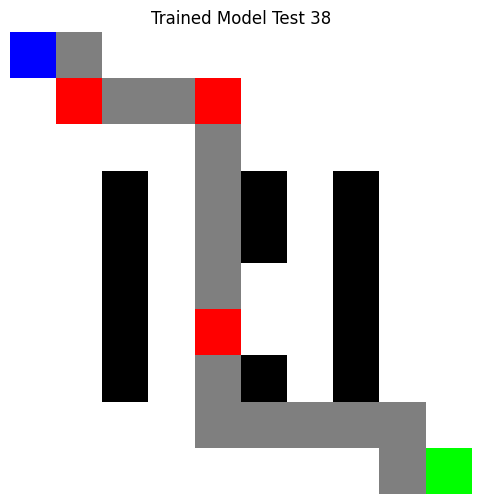


Episode 39, Reward: 580.56, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



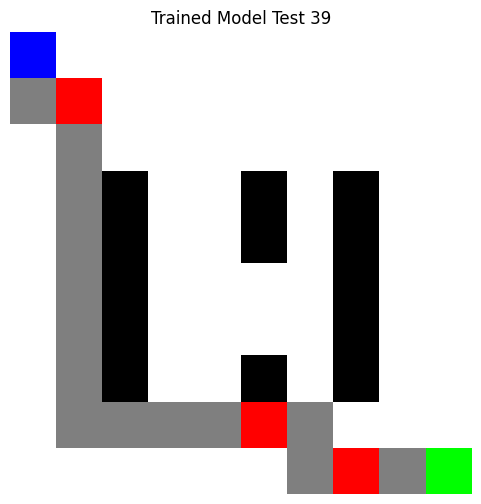


Episode 40, Reward: 612.32, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 4), (2, 3), (2, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



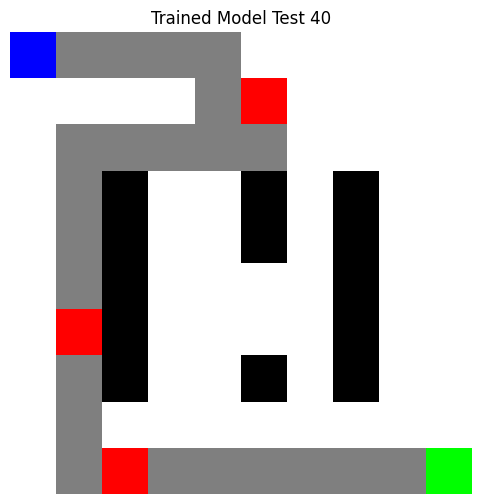


Episode 41, Reward: 587.41, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



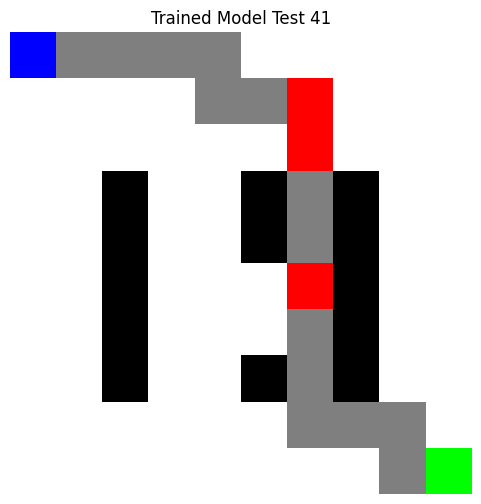


Episode 42, Reward: 591.26, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (2, 1), (2, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



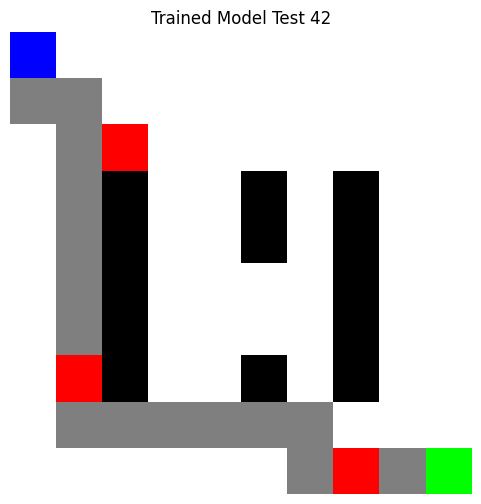


Episode 43, Reward: 602.55, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]



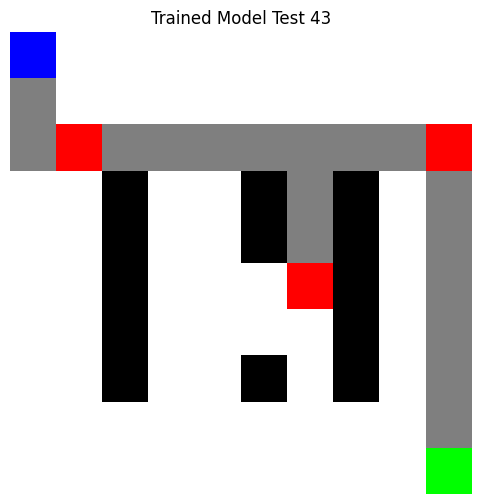


Episode 44, Reward: 610.48, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (9, 2), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (8, 9), (9, 9)]



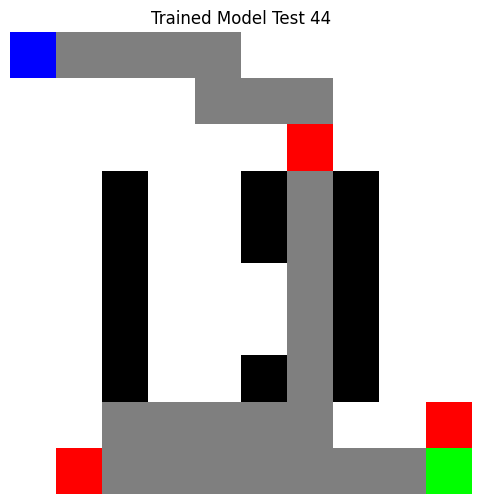


Episode 45, Reward: 598.50, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



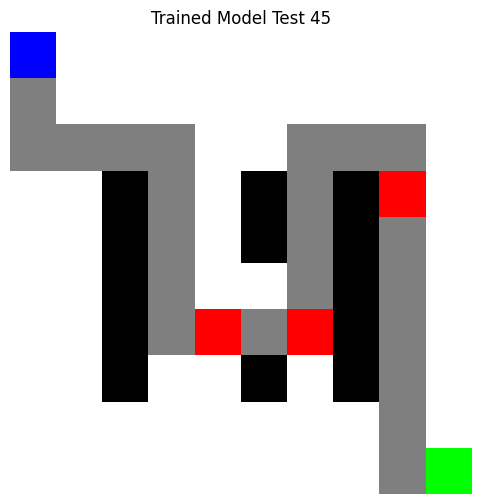


Episode 46, Reward: 615.74, CarriesCollected total: 3, StepsTaken: 36, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (6, 4), (6, 3), (7, 3), (8, 3), (9, 3), (9, 2), (9, 3), (8, 3), (8, 4), (8, 5), (8, 6), (7, 6), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



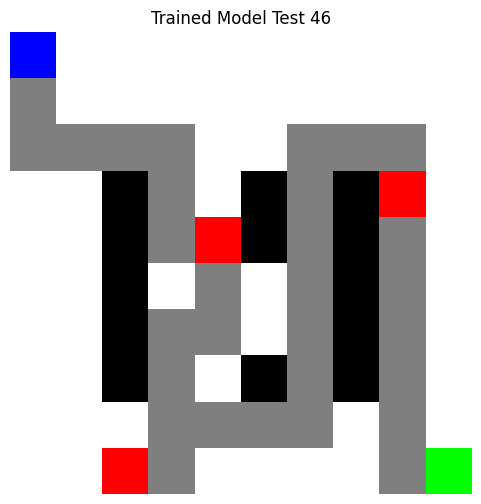


Episode 47, Reward: 629.09, CarriesCollected total: 3, StepsTaken: 32, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (2, 7), (2, 8), (2, 7), (2, 6), (2, 5), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 3), (8, 2), (9, 2), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



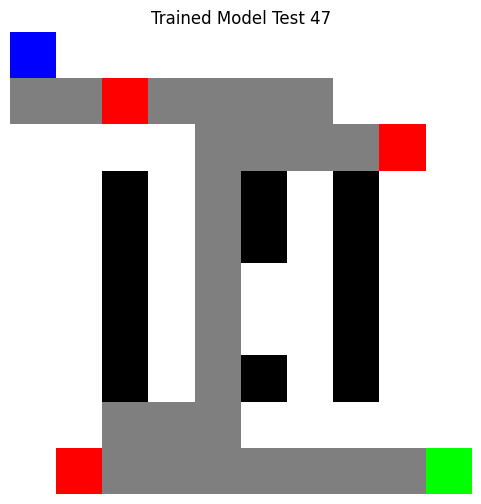


Episode 48, Reward: 577.75, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



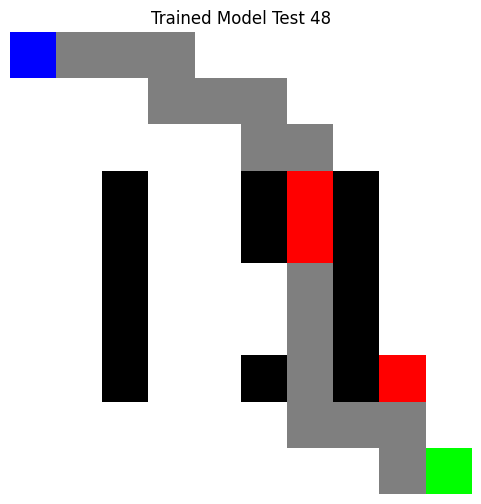


Episode 49, Reward: 588.73, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



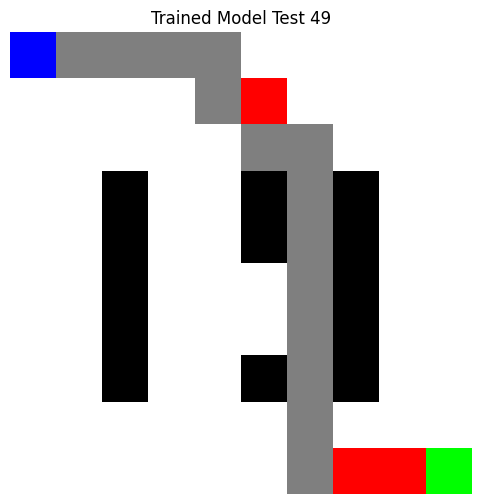


Episode 50, Reward: 588.30, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



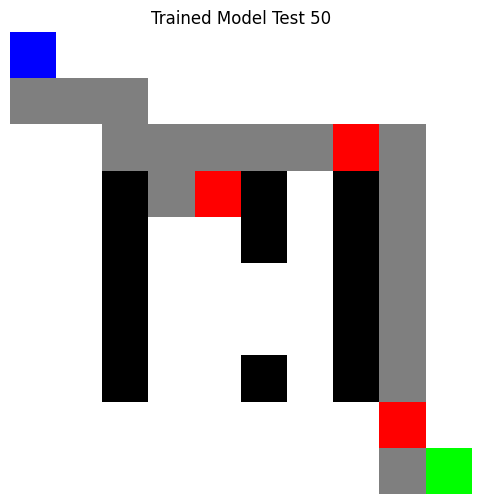


Episode 51, Reward: 628.52, CarriesCollected total: 3, StepsTaken: 32, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (9, 4), (9, 5), (9, 6), (8, 6), (7, 6), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



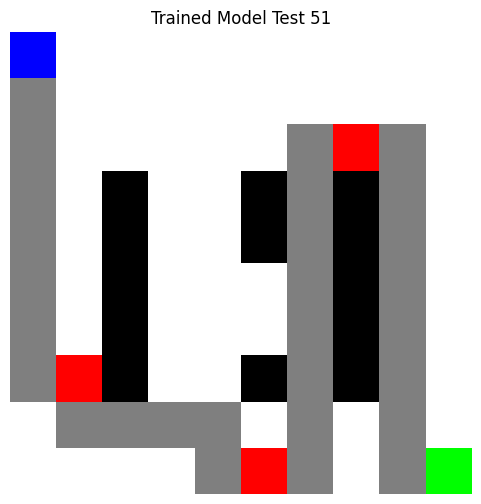


Episode 52, Reward: 614.34, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (7, 3), (8, 3), (8, 2), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



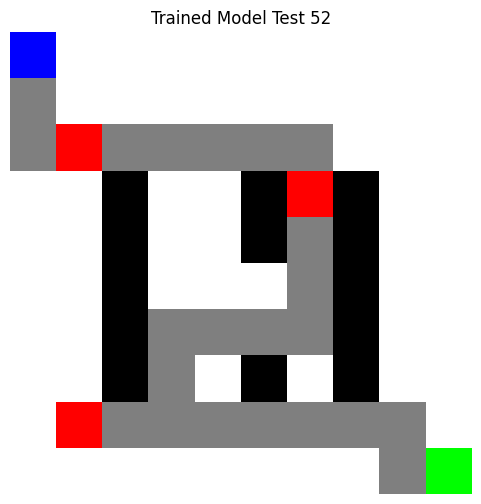


Episode 53, Reward: 592.14, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]



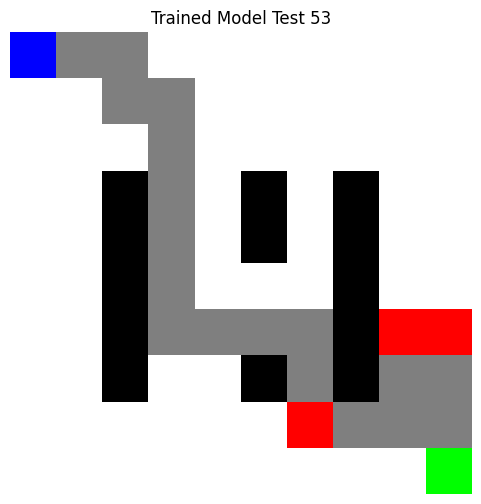


Episode 54, Reward: 580.65, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



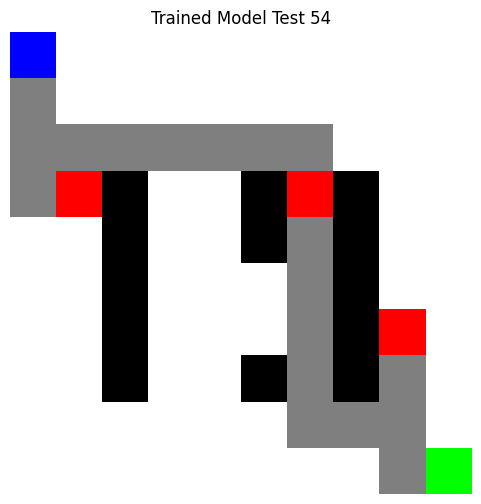


Episode 55, Reward: 577.39, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



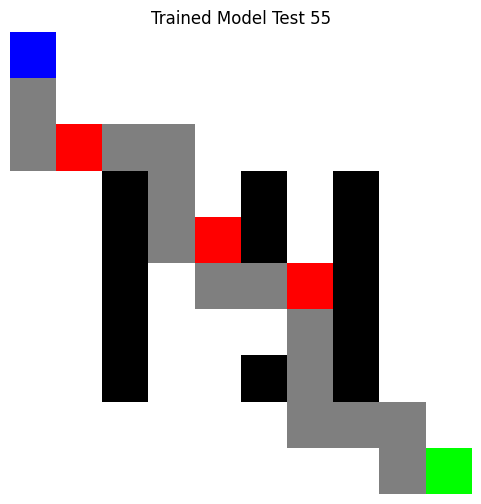


Episode 56, Reward: 621.82, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (6, 1), (5, 1), (4, 1), (3, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (1, 7), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



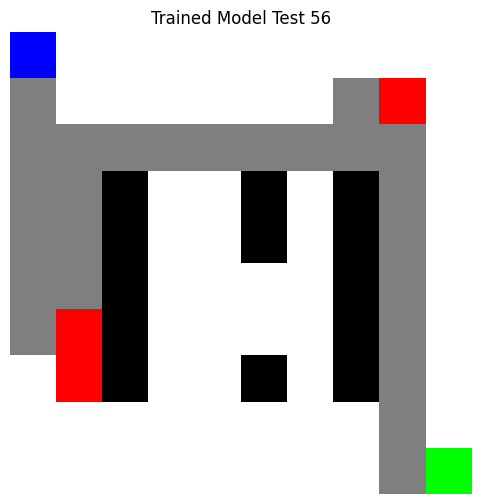


Episode 57, Reward: 589.23, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]



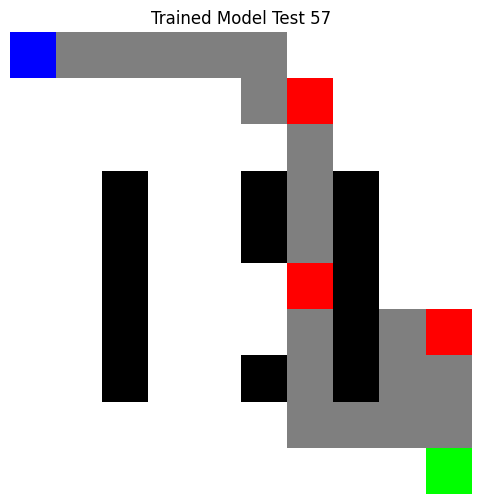


Episode 58, Reward: 620.49, CarriesCollected total: 3, StepsTaken: 31, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (9, 4), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



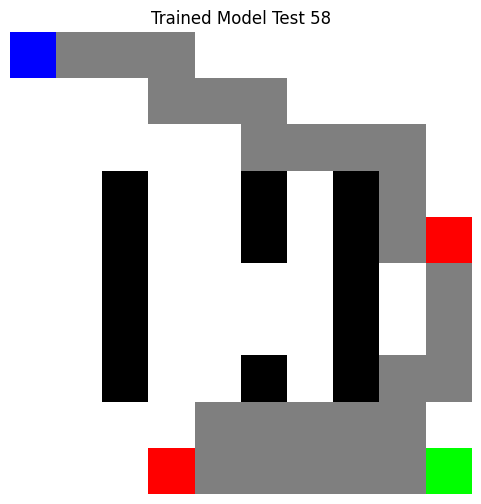


Episode 59, Reward: 277.30, CarriesCollected total: 3, StepsTaken: 50, Path Taken: [(0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (3, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (7, 4), (8, 4)]



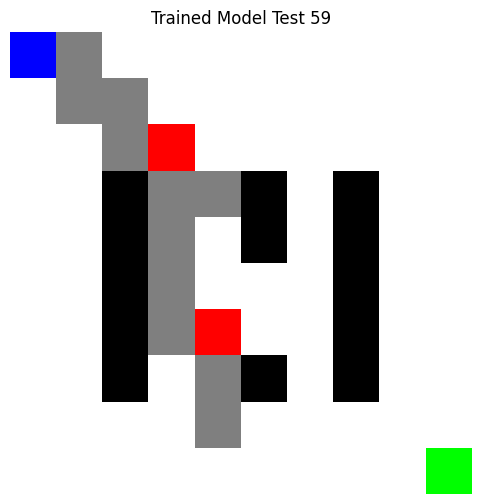


Episode 60, Reward: 586.92, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (9, 3), (8, 3), (7, 3), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



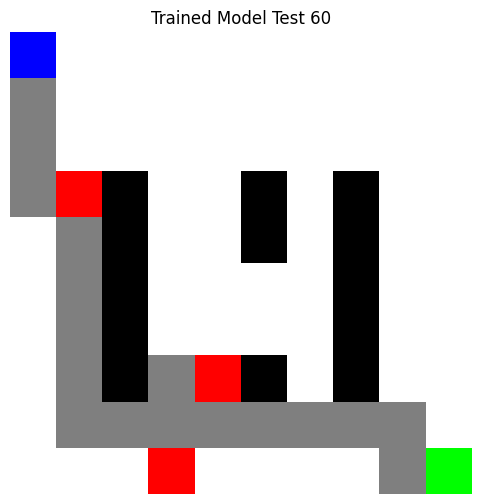


Episode 61, Reward: 587.36, CarriesCollected total: 3, StepsTaken: 28, Path Taken: [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (8, 7), (8, 6), (7, 6), (6, 6), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



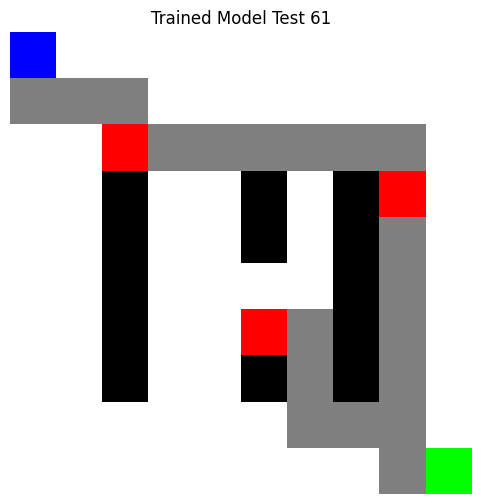


Episode 62, Reward: 589.98, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]



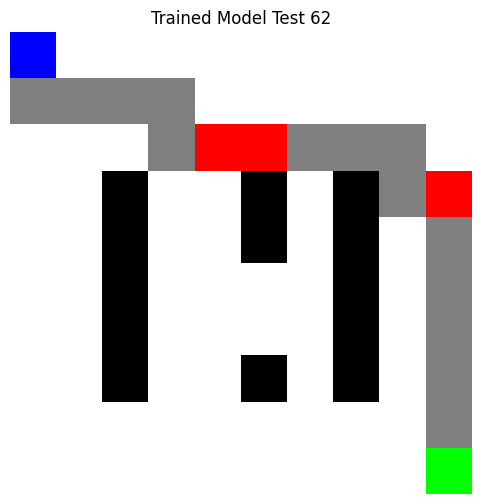


Episode 63, Reward: 598.80, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



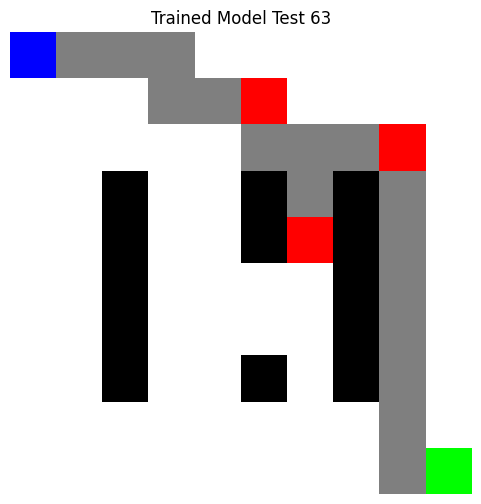


Episode 64, Reward: 581.87, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (3, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



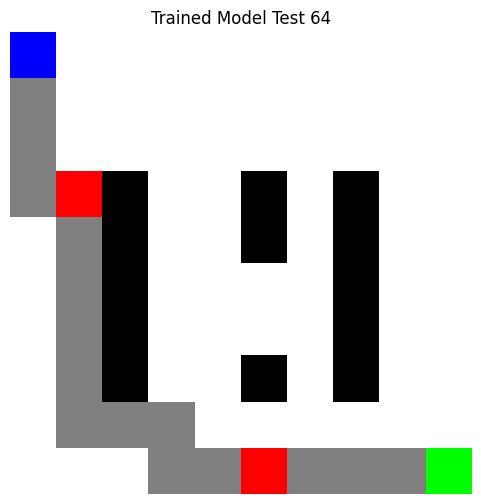


Episode 65, Reward: 623.64, CarriesCollected total: 3, StepsTaken: 32, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (8, 6), (7, 6), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



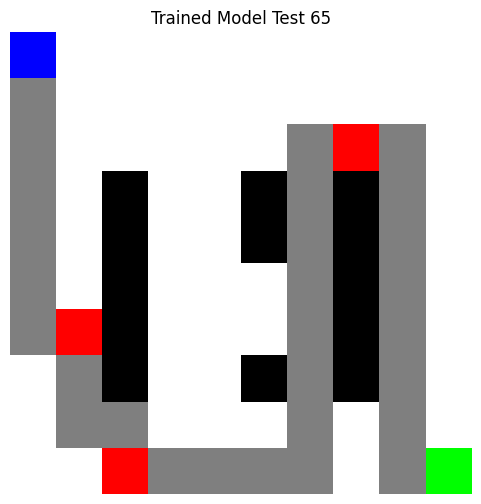


Episode 66, Reward: 585.47, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (8, 9), (9, 9)]



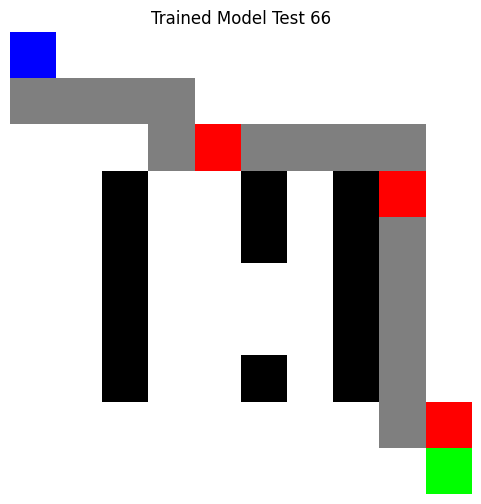


Episode 67, Reward: 613.18, CarriesCollected total: 3, StepsTaken: 34, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (7, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



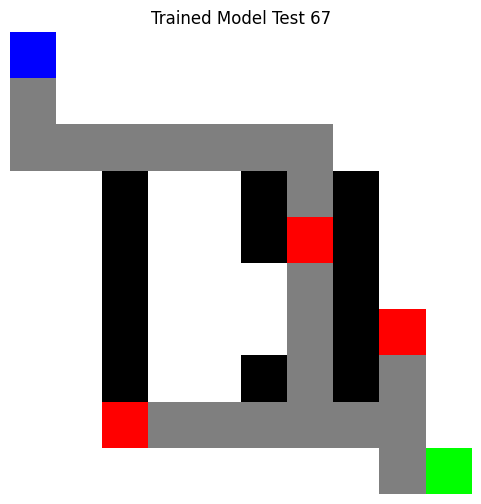


Episode 68, Reward: 609.57, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (6, 3), (7, 3), (8, 3), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



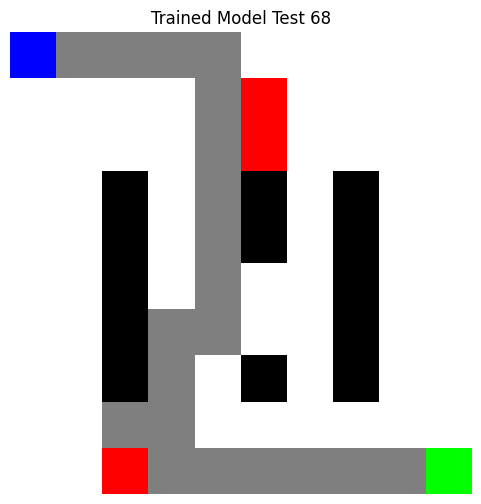


Episode 69, Reward: 627.40, CarriesCollected total: 3, StepsTaken: 32, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]



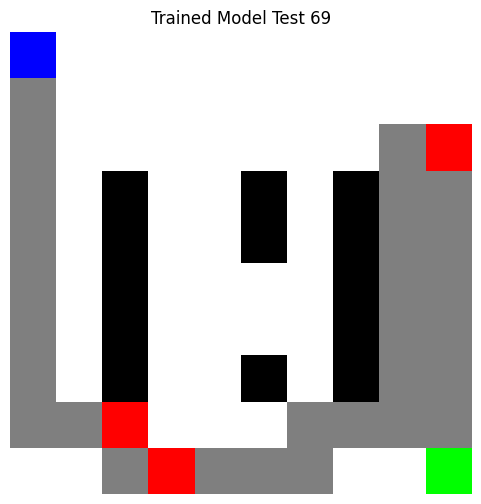


Episode 70, Reward: 606.79, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (1, 1), (2, 1), (2, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]



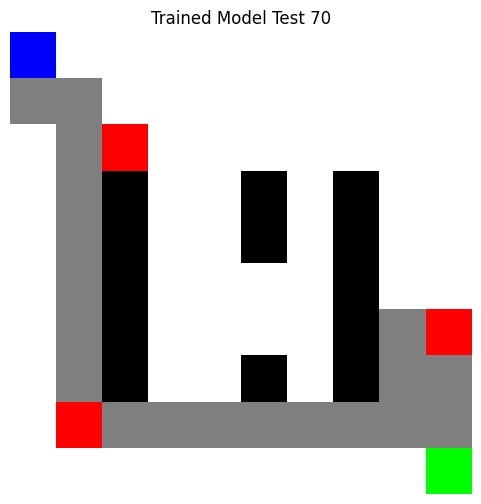


Episode 71, Reward: 594.05, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (8, 8), (8, 7), (8, 6), (7, 6), (6, 6), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



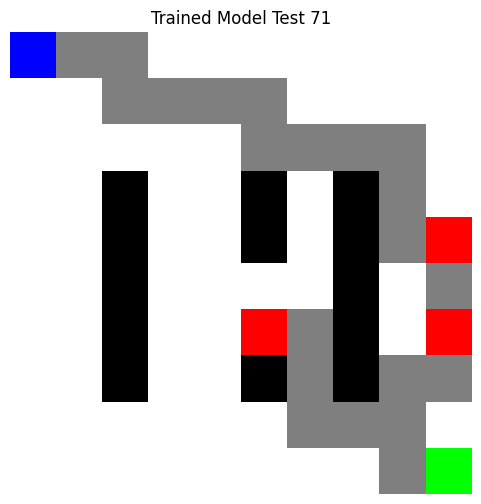


Episode 72, Reward: -18.94, CarriesCollected total: 0, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (5, 3), (6, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4)]



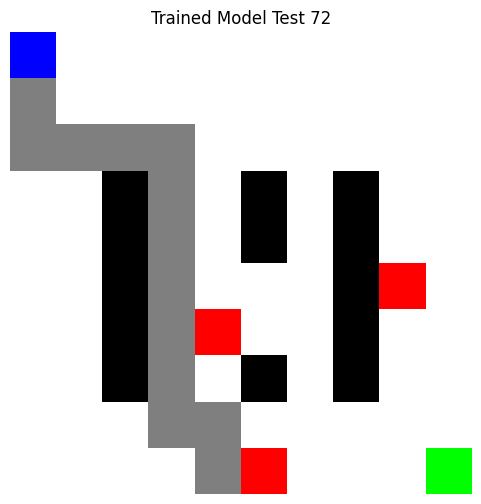


Episode 73, Reward: 582.24, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (8, 8), (8, 9), (9, 9)]



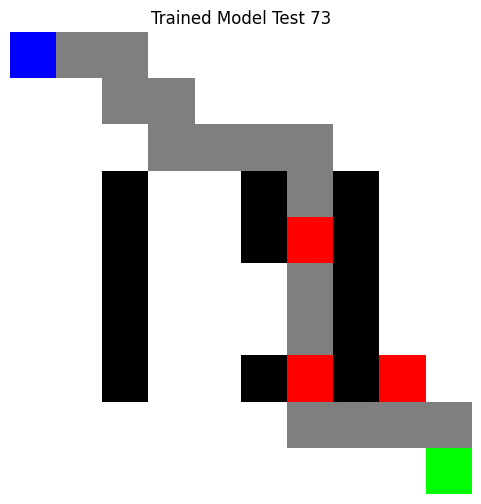


Episode 74, Reward: 604.93, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (7, 4), (6, 4), (6, 5), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



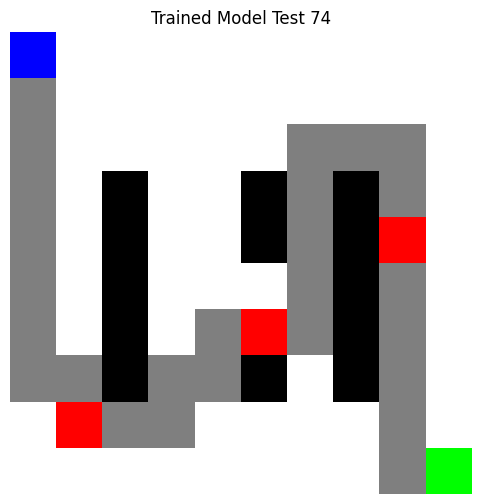


Episode 75, Reward: 582.05, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (1, 7), (1, 8), (2, 8), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



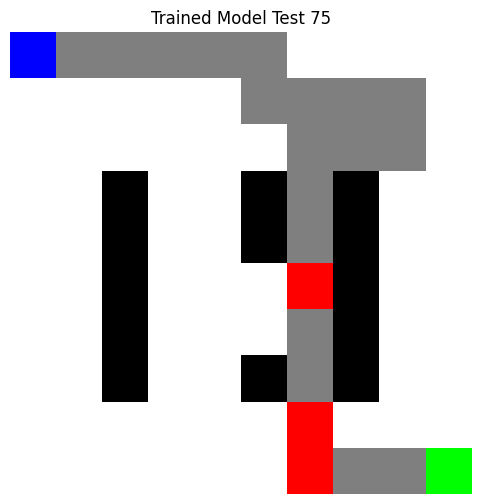


Episode 76, Reward: 587.34, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (5, 9), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



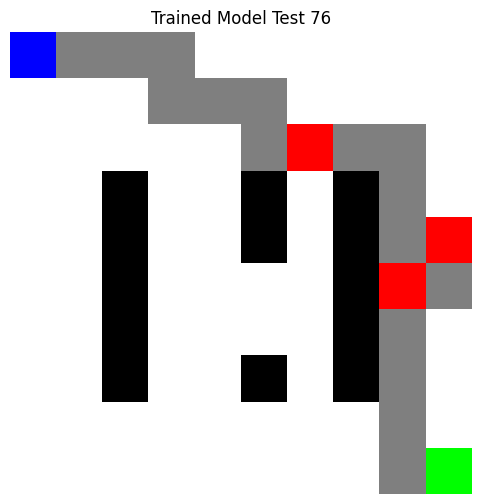


Episode 77, Reward: 64.18, CarriesCollected total: 1, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1), (6, 1), (7, 1)]



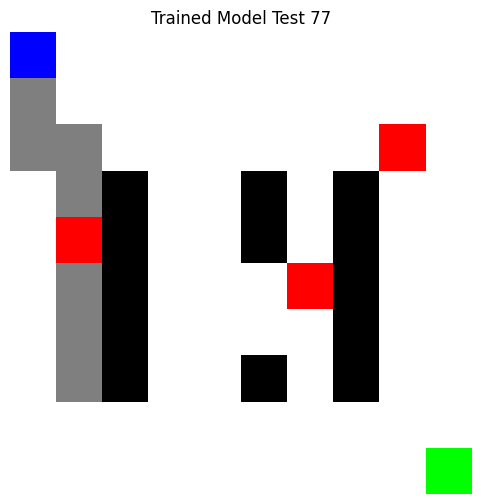


Episode 78, Reward: 583.87, CarriesCollected total: 3, StepsTaken: 18, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



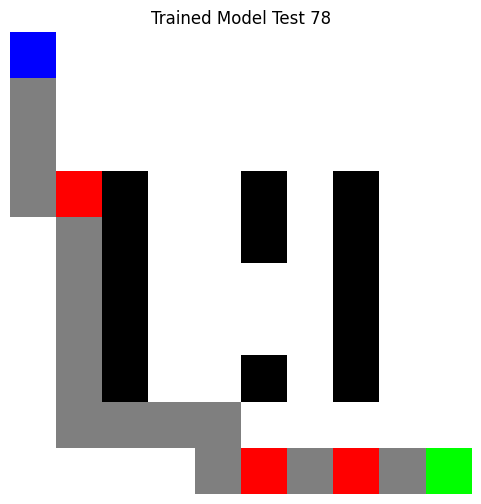


Episode 79, Reward: 597.92, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



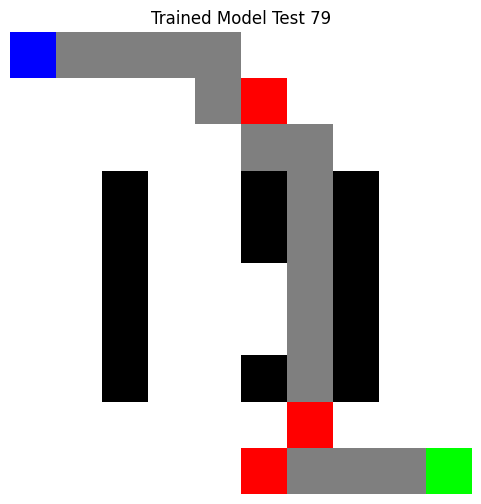


Episode 80, Reward: 614.99, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (7, 3), (8, 3), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



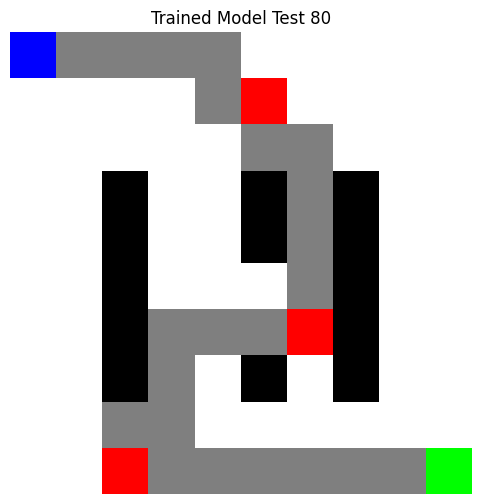


Episode 81, Reward: 590.11, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



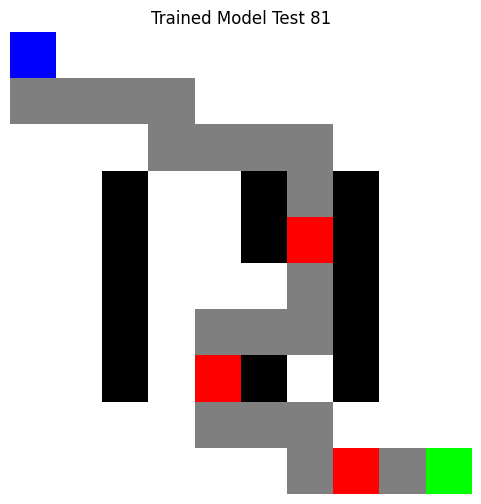


Episode 82, Reward: 579.03, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (5, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]



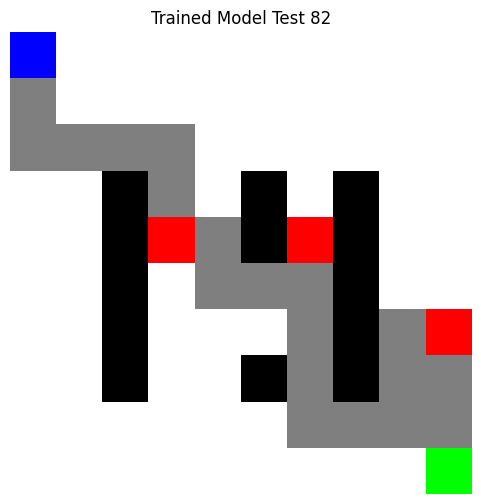


Episode 83, Reward: 595.66, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



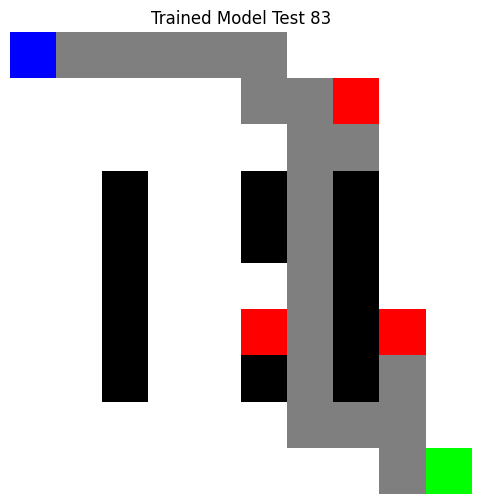


Episode 84, Reward: 586.59, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (5, 9), (5, 8), (6, 8), (7, 8), (8, 8), (8, 9), (9, 9)]



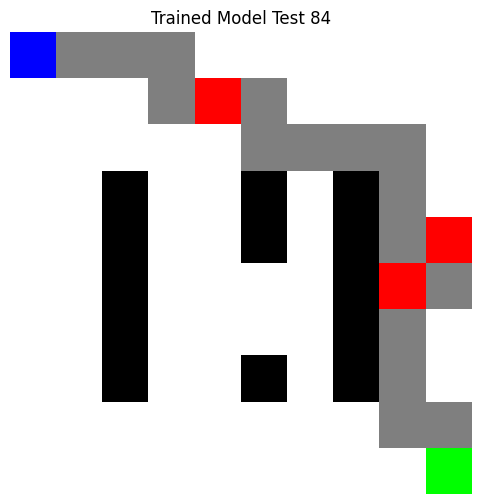


Episode 85, Reward: 589.45, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (3, 3), (3, 4), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



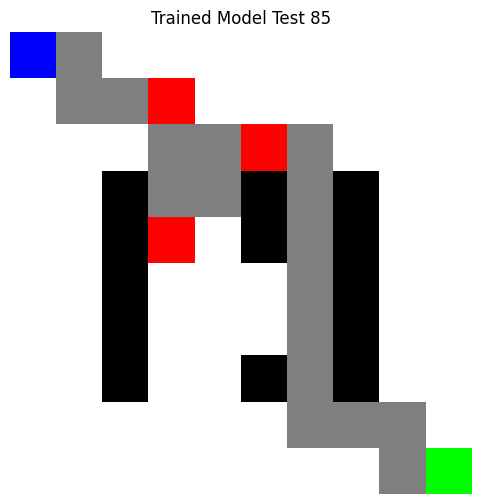


Episode 86, Reward: 596.36, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (9, 7), (9, 8), (9, 9)]



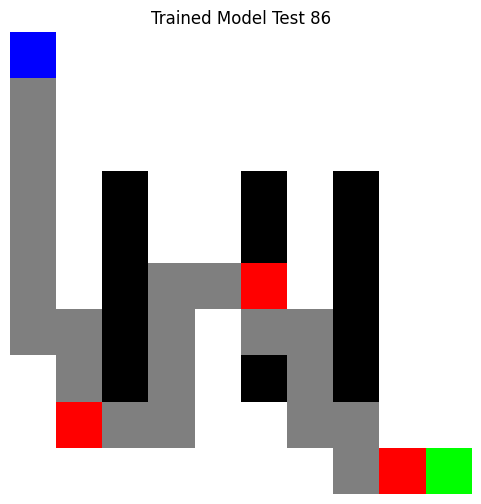


Episode 87, Reward: -32.27, CarriesCollected total: 0, StepsTaken: 50, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 8), (8, 9)]



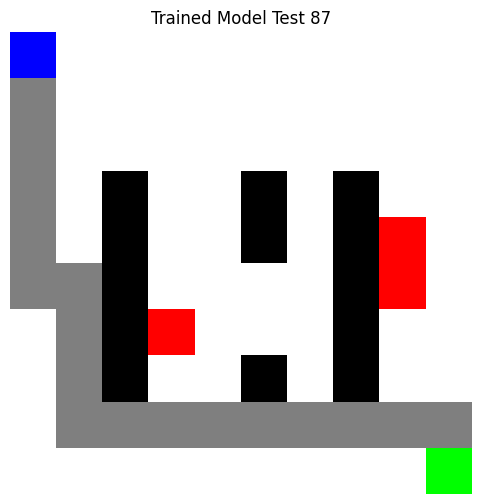


Episode 88, Reward: 578.17, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (8, 9), (9, 9)]



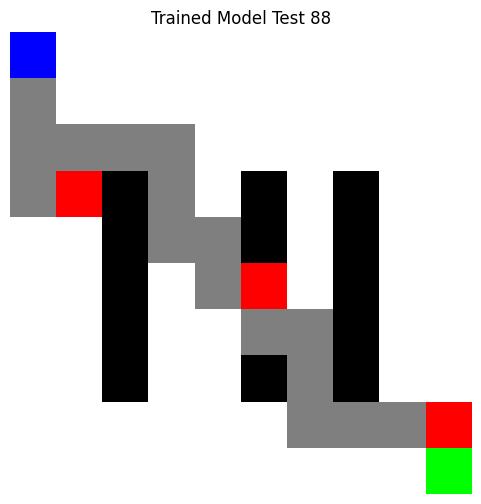


Episode 89, Reward: 588.06, CarriesCollected total: 3, StepsTaken: 24, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



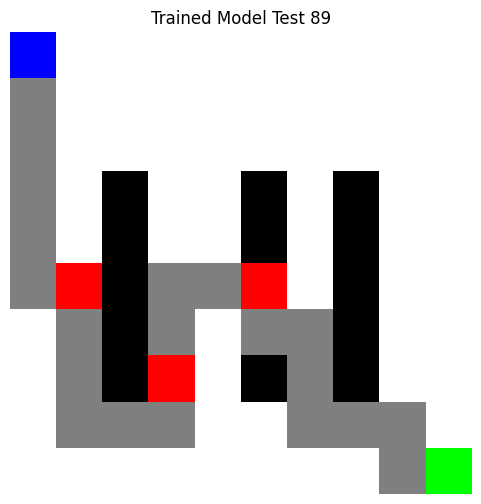


Episode 90, Reward: 594.67, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (7, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



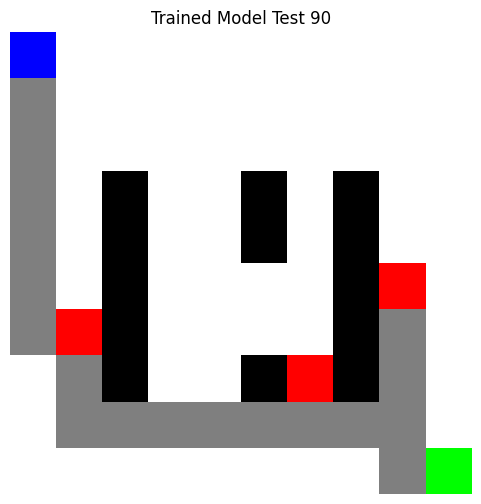


Episode 91, Reward: -193.19, CarriesCollected total: 1, StepsTaken: 5, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (3, 1)]



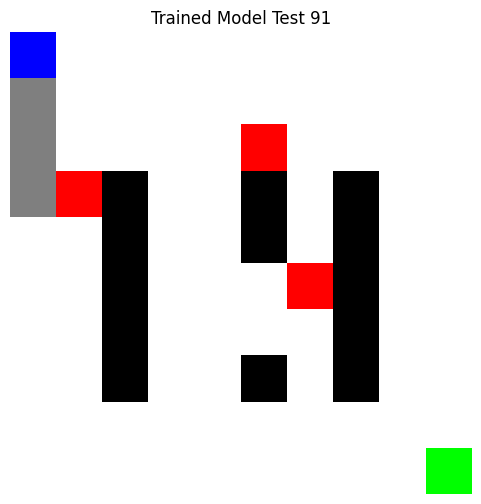


Episode 92, Reward: 596.66, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]



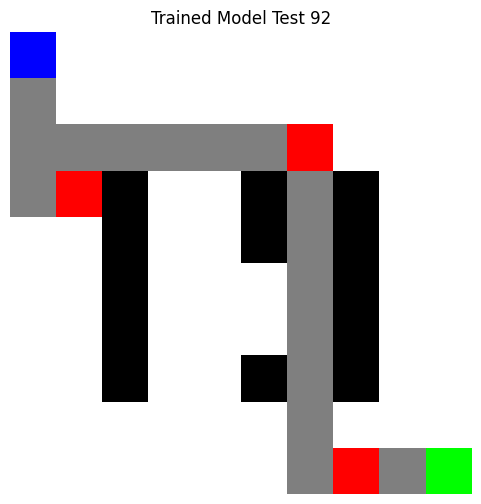


Episode 93, Reward: 596.67, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 5), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



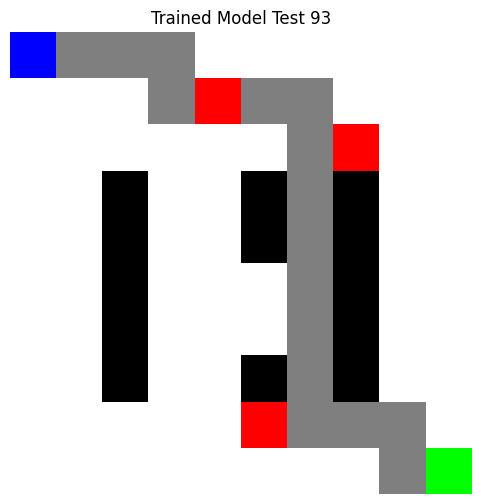


Episode 94, Reward: 579.87, CarriesCollected total: 3, StepsTaken: 20, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (8, 7), (8, 8), (9, 8), (9, 9)]



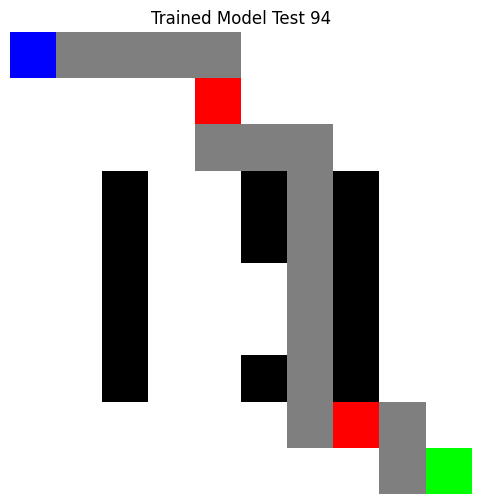


Episode 95, Reward: 585.12, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (8, 7), (8, 6), (7, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



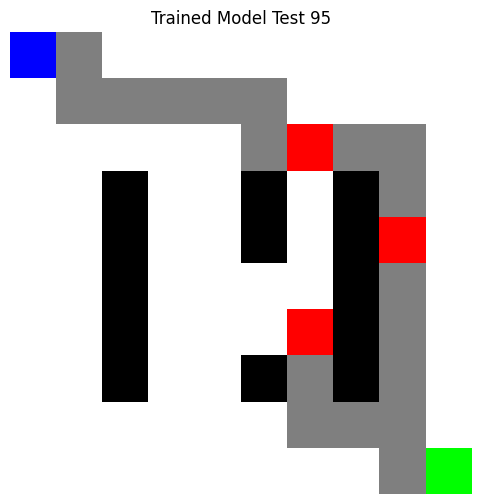


Episode 96, Reward: 595.60, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (1, 7), (2, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (6, 9), (7, 9), (8, 9), (8, 8), (8, 7), (8, 8), (9, 8), (9, 9)]



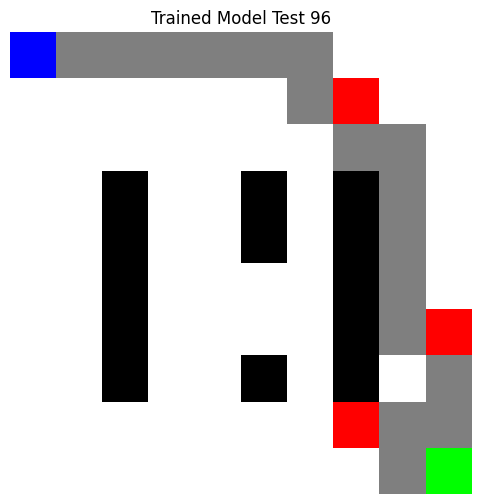


Episode 97, Reward: 616.12, CarriesCollected total: 3, StepsTaken: 30, Path Taken: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 9)]



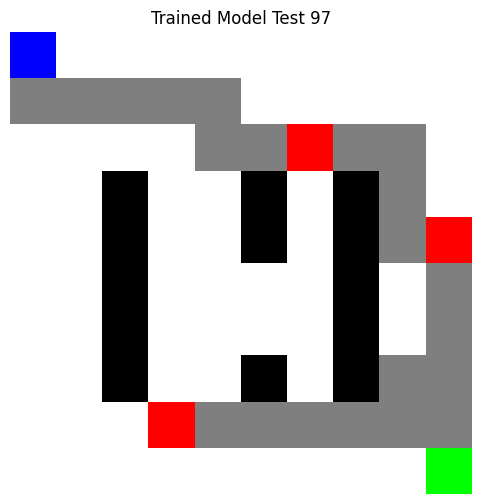


Episode 98, Reward: 597.34, CarriesCollected total: 3, StepsTaken: 22, Path Taken: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]



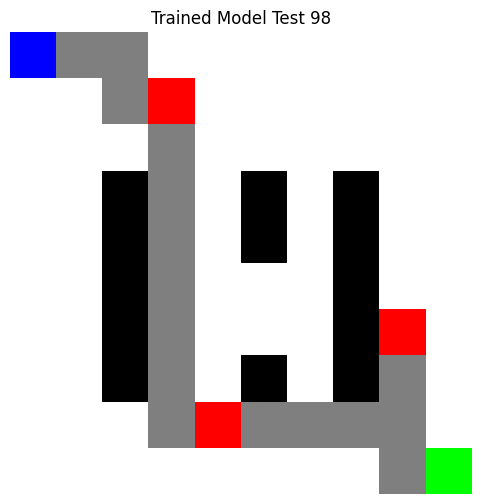


Episode 99, Reward: 591.26, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (5, 1), (4, 1), (3, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]



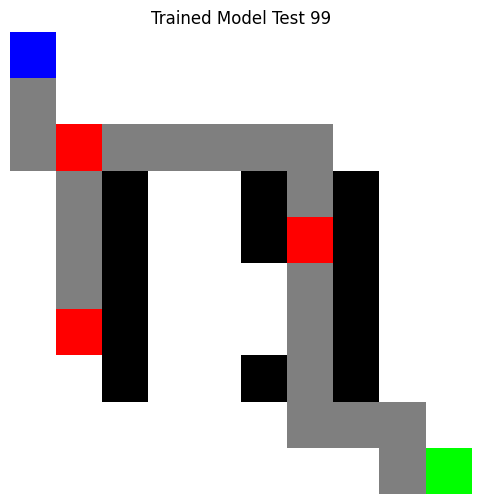


Episode 100, Reward: 614.08, CarriesCollected total: 3, StepsTaken: 26, Path Taken: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (7, 4), (8, 4), (9, 4), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



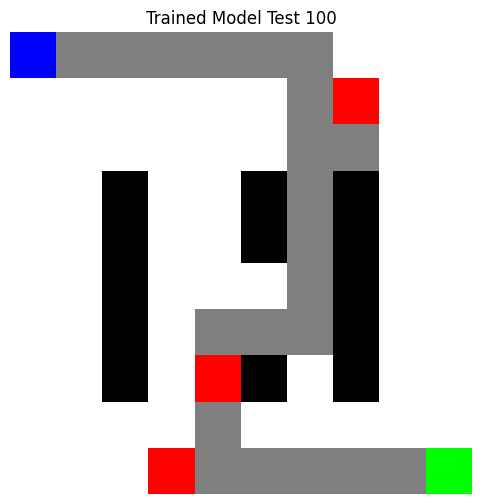


Test Summary:
Last100AvgReward: 555.94
CarriesCollected(total): 288
SuccessTests: 92
AvgStepsTaken: 25.20



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def test_trained_model(model_path, num_tests=10, grid_size=10):
    env = PickAndPlaceEnv(grid_size=grid_size)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Load the trained model
    model = build_rainbow_distributional_q_network(state_dim, action_dim)
    model.load_weights(model_path)

    successful_tests = 0
    total_rewards = []
    total_carries = []
    total_steps_list = []

    for i in range(num_tests):
        # Reset the environment
        state = env.reset()
        done = False
        total_reward = 0
        carries_collected = 0
        steps = 0
        path_taken = []

        # Store initial carry positions for visualization
        original_carry_positions = list(env.carries)

        # Visualization setup
        grid = np.ones((grid_size, grid_size, 3))
        for obs in env.obstacles:
            grid[obs] = [0, 0, 0]  # Black for obstacles
        for carry in original_carry_positions:
            grid[carry] = [1, 0, 0]  # Red for carries

        while not done and steps < 50:
            steps += 1

            # Choose action using the trained model
            q_dist = model.predict(state.reshape(1, -1), verbose=0)[0]
            q_values = np.sum(q_dist * supports, axis=1)
            action = np.argmax(q_values)

            # Execute action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            path_taken.append(tuple(env.agent_pos))

            if reward == 99:
                carries_collected += 1

            # Update state
            state = next_state

            # Update visualization grid for empty areas only
            agent_pos = tuple(env.agent_pos)
            if agent_pos not in original_carry_positions and agent_pos != env.final_pos and agent_pos != tuple(env.start_pos):
                grid[agent_pos] = [0.5, 0.5, 0.5]  # Grey only for empty path

        total_rewards.append(total_reward)
        total_carries.append(carries_collected)
        total_steps_list.append(steps)

        # Episode Debug Info
        print()
        print(f"Episode {i + 1}, "
              f"Reward: {total_reward:.2f}, "
              f"CarriesCollected total: {carries_collected}, "
              f"StepsTaken: {steps}, "
              f"Path Taken: {path_taken}")
        print()

        # Plot the result
        grid[tuple(env.start_pos)] = [0, 0, 1]  # Blue for start
        grid[env.final_pos] = [0, 1, 0]  # Green for final
        for carry in original_carry_positions:
            grid[carry] = [1, 0, 0]  # Keep original carry positions in red

        plt.figure(figsize=(6, 6))
        plt.imshow(grid)
        plt.title(f"Trained Model Test {i + 1}")
        plt.axis('off')
        plt.show()

        if not env.carries and tuple(env.agent_pos) == env.final_pos:
            successful_tests += 1

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps_list)
    total_carries_collected = sum(total_carries)

    print(f"\nTest Summary:")
    print(f"Last{num_tests}AvgReward: {avg_reward:.2f}")
    print(f"CarriesCollected(total): {total_carries_collected}")
    print(f"SuccessTests: {successful_tests}")
    print(f"AvgStepsTaken: {avg_steps:.2f}\n")

# Example usage:
model_path = '/content/drive/MyDrive/checkpoints_lastt/rainbow_model_12000.keras'
test_trained_model(model_path, num_tests=100, grid_size=10)
